<a href="https://colab.research.google.com/github/phps-28/Data-Science-PGEBM/blob/master/Mestrado/Projeto/T_1/T_1_22-22-23-24_2-06_08_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Controle de Versões

##### Definição da codificação
 Ex: (1.0.0.0)
- 1: Tipo de modelo de rede neural
- 0: Mudanças lógica, código ou estratégia
- 0: Mudança de parâmetros
- 0: Mudança de base de dados
<br>
<br>

# Importação das bibliotecas

In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import pandas as pd
import cv2
from google.colab import files
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

## **Resetando a base de imagens**

In [2]:
# # deletando os diretorios

# import shutil

# def delete_directory(directory_path):
#   """Deletes a directory and its contents.

#   Args:
#     directory_path: The path to the directory to delete.
#   """
#   try:
#     shutil.rmtree(directory_path)
#     print(f"Directory '{directory_path}' deleted successfully.")
#   except FileNotFoundError:
#     print(f"Directory '{directory_path}' not found.")
#   except OSError as e:
#     print(f"Error deleting directory '{directory_path}': {e}")

# # Example usage:
# delete_directory("/content/test")
# delete_directory("/content/train")
# delete_directory("/content/validation")
# delete_directory("/content/Base_2_Classes_B_R")
# delete_directory("/content/Downloads")

# **Reset das Variáveis**

In [3]:
# %reset -f

# **Rodada 1**

## Subindo o arquivo zipado com as imagens

In [4]:
!unzip -q Base_2_Classes_B_R.zip
!ls

Base_2_Classes_B_R  Base_2_Classes_B_R.zip  Downloads  sample_data


In [5]:
!ls Base_2_Classes_B_R

00R  01B


In [6]:
import os

# Todas as categorias
num_skipped = 0
for folder_name in ("00R", "01B"): # descrevendo as pastas presentes dentro do arquivo main "Base"
    folder_path = os.path.join("Base_2_Classes_B_R", folder_name) # juntando o caminho de cada uma das pastas com o caminho da main pasta
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) # estabelecendo o caminho completo de cada imagem dentro da pasta main e subpastas
        try:
            fobj = open(fpath, "rb") # lendo e abrindo cada uma das imagens
            is_pfif = tf.compat.as_bytes("PFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.png'
            # (T.1.0.3.1)
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.jpg'
            #
        finally:
            fobj.close()

print("Deletadas %d imagens" % num_skipped)

Deletadas 0 imagens


# Gerando os Datasets de treino, teste e validação randomicamente

In [7]:
import os
import random
from shutil import copyfile

# Diretório original das imagens
original_dataset_dir = '/content/Base_2_Classes_B_R'

# Diretório de destino para os conjuntos de treinamento, teste e validação
base_dir = '/content'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

val_dir = os.path.join(base_dir, 'validation')
os.makedirs(val_dir, exist_ok=True)

# Lista de classes (subdiretórios) no diretório original
classes = os.listdir(original_dataset_dir)

# Defina as proporções de imagens para treinamento (80%), teste (10%) e validação (10%)
train_split = 0.8
test_split = 0.1

# Itera sobre cada classe para criar os conjuntos de treinamento, teste e validação
for class_name in classes:
    class_dir = os.path.join(original_dataset_dir, class_name)

    # Lista de todas as imagens na classe
    images = os.listdir(class_dir)

    # Embaralha a lista de imagens para dividir aleatoriamente
    random.shuffle(images)

    # Calcula os índices para dividir entre treinamento, teste e validação
    train_index = int(len(images) * train_split)
    test_index = train_index + int(len(images) * test_split)

    # Lista de imagens para treinamento, teste e validação
    train_images = images[:train_index]
    test_images = images[train_index:test_index]
    val_images = images[test_index:]

    # Cria os subdiretórios de treinamento, teste e validação para a classe
    train_class_dir = os.path.join(train_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)

    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(test_class_dir, exist_ok=True)

    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(val_class_dir, exist_ok=True)

    # Copia as imagens para os diretórios de treinamento, teste e validação
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_class_dir, img)
        copyfile(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_class_dir, img)
        copyfile(src, dst)

    for img in val_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(val_class_dir, img)
        copyfile(src, dst)

print('Feito!')


Feito!


# Dataset Treino + Data Augmentation

In [8]:
gerador_treinamento = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input,
                                        #Data Augmentation
                                        zoom_range=0.2,
                                        rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

dataset_treinamento = gerador_treinamento.flow_from_directory('/content/train',
                                                              target_size=(224,224),
                                                              color_mode = 'rgb',
                                                              batch_size=16,
                                                              class_mode='categorical',
                                                              shuffle = True) # as imagens do dataset serão embaralhadas antes de cada época

Found 604 images belonging to 2 classes.


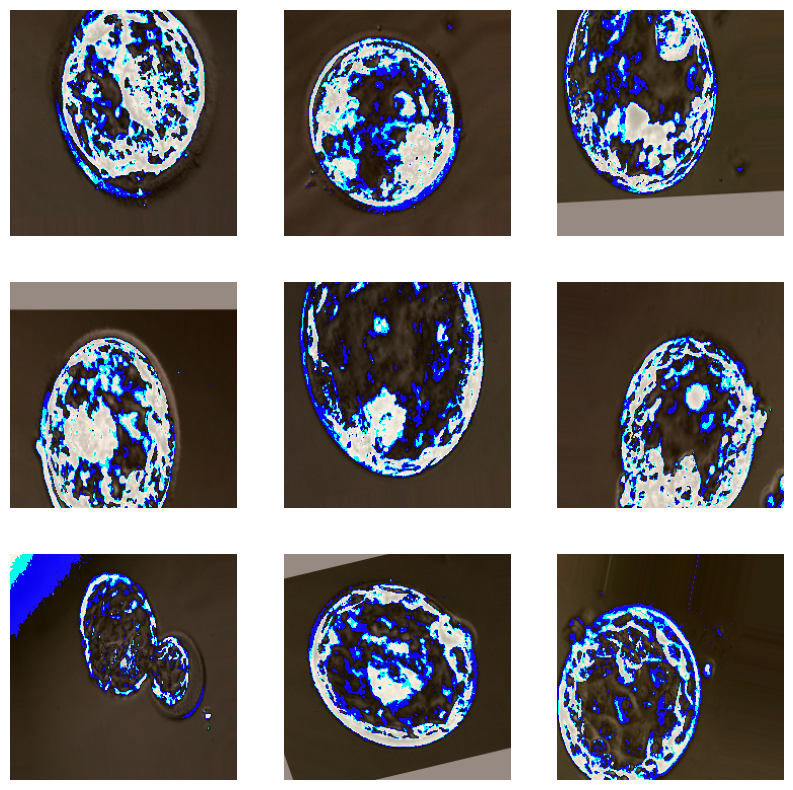

In [9]:
image_batch, label_batch = next(iter(dataset_treinamento))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image_batch[i].astype("uint8"), cmap=plt.cm.binary) #cmap='gray', vmin=0, vmax=255
  # plt.title(label_batch[i])
  label = label_batch[i]
  plt.axis("off")

#plt.savefig("Exemplo_Data_Augmentation.pdf"); # salvar a figura em pdf

In [10]:
dataset_treinamento.class_indices

{'00R': 0, '01B': 1}

In [11]:
dataset_treinamento.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Quantidade 0:  172
Quantidade 1:  432


/tmp/ipython-input-264157126.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['0', '1'], y=[len(lista_zero), len(lista_um)], palette=['blue', 'green']);


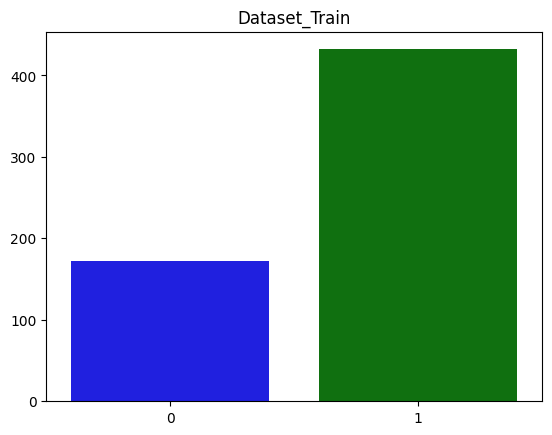

In [12]:
lista_zero = []
lista_um = []

for i in range(len(dataset_treinamento.classes)):
  if dataset_treinamento.classes[i] == 0:
    lista_zero.append(i)
  else:
    lista_um.append(i)

print(f'Quantidade 0: ', len(lista_zero))
print(f'Quantidade 1: ', len(lista_um))

# Conte a quantidade de ocorrências de cada valor nas listas
contagem_um = lista_um.count(1)
contagem_zero = lista_zero.count(0)

# Crie um gráfico de barras com os dados
sns.barplot(x=['0', '1'], y=[len(lista_zero), len(lista_um)], palette=['blue', 'green']);
plt.title("Dataset_Train")
# Exiba o gráfico
plt.show();

# Dataset Validação

In [13]:
gerador_validacao = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

dataset_validacao = gerador_validacao.flow_from_directory('/content/validation',
                                                              target_size=(224,224),
                                                              color_mode = 'rgb',
                                                              batch_size=16,
                                                              class_mode='categorical',
                                                              shuffle = False) # as imagens do dataset NÃO serão embaralhadas antes de cada época na validação. É um teste do modelo depois de cada época

Found 76 images belonging to 2 classes.


Quantidade 0:  22
Quantidade 1:  54


/tmp/ipython-input-224920879.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['0', '1'], y=[len(lista_zero), len(lista_um)], palette=['blue', 'green']);


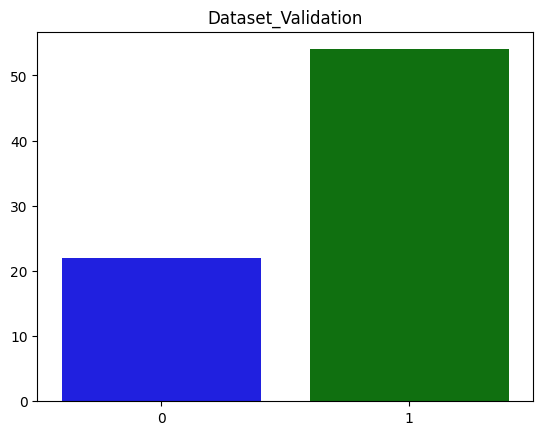

In [14]:
lista_zero = []
lista_um = []

for i in range(len(dataset_validacao.classes)):
  if dataset_validacao.classes[i] == 0:
    lista_zero.append(i)
  else:
    lista_um.append(i)

print(f'Quantidade 0: ', len(lista_zero))
print(f'Quantidade 1: ', len(lista_um))

# Conte a quantidade de ocorrências de cada valor nas listas
contagem_um = lista_um.count(1)
contagem_zero = lista_zero.count(0)

# Crie um gráfico de barras com os dados
sns.barplot(x=['0', '1'], y=[len(lista_zero), len(lista_um)], palette=['blue', 'green']);
plt.title("Dataset_Validation")
# Exiba o gráfico
plt.show();

# Dataset Teste

In [15]:
gerador_teste = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

dataset_teste = gerador_teste.flow_from_directory('/content/test',
                                                  target_size=(224,224),
                                                  color_mode = 'rgb',
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 75 images belonging to 2 classes.


Quantidade 0:  21
Quantidade 1:  54


/tmp/ipython-input-1903680227.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['0', '1'], y=[len(lista_zero), len(lista_um)], palette=['blue', 'green']);


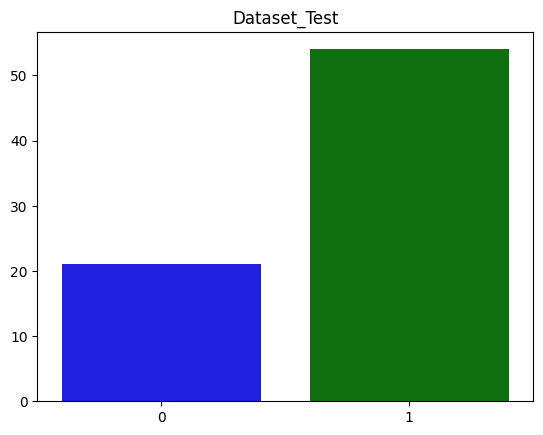

In [16]:
lista_zero = []
lista_um = []

for i in range(len(dataset_teste.classes)):
  if dataset_teste.classes[i] == 0:
    lista_zero.append(i)
  else:
    lista_um.append(i)

print(f'Quantidade 0: ', len(lista_zero))
print(f'Quantidade 1: ', len(lista_um))

# Conte a quantidade de ocorrências de cada valor nas listas
contagem_um = lista_um.count(1)
contagem_zero = lista_zero.count(0)

# Crie um gráfico de barras com os dados
sns.barplot(x=['0', '1'], y=[len(lista_zero), len(lista_um)], palette=['blue', 'green']);
plt.title("Dataset_Test")
# Exiba o gráfico
plt.show();

# Rede neural pré-treinada
- Documentação: https://keras.io/api/applications/


## VGG-19

In [17]:
# modelo_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

## ResNet50

In [18]:
modelo_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


## ResNet101

In [19]:
# modelo_base = tf.keras.applications.ResNet101(weights='imagenet', include_top=False)

## ResNet152V2

In [20]:
# modelo_base = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False)

In [21]:
modelo_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [22]:
len(modelo_base.layers)

175

In [23]:
for layer in modelo_base.layers:
  #print(layer)
  layer.trainable = False

In [24]:
for layer in modelo_base.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True> F

# Camada densa personalizada

In [25]:
modelo_base.output

<KerasTensor shape=(None, None, None, 2048), dtype=float32, sparse=False, ragged=False, name=keras_tensor_174>

In [26]:
from functools import partial

RegularizadedDense = partial(keras.layers.Dense,
                             activation = "elu",
                             kernel_initializer = "he_normal",
                             kernel_regularizer = keras.regularizers.L1(0.001))

head_model = modelo_base.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = RegularizadedDense(1029)(head_model)
head_model = RegularizadedDense(514)(head_model)
head_model = RegularizadedDense(257)(head_model)
head_model = RegularizadedDense(units=2, activation='softmax')(head_model) # Função de ativação = "softmax" para ver a probabilidade entre as duas classes

print('Feito!')

Feito!


# Construção e treinamento da rede neural

In [27]:
modelo_base.input

<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor>

In [28]:
network1 = Model(inputs = modelo_base.input, outputs = head_model)

In [29]:
for layer in network1.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True> F

In [30]:
network1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 26,358,424 (100.55 MB)

 Trainable params: 2,770,712 (10.57 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Compilando o Modelo

In [31]:
# Compilar o modelo
network1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4), loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(curve='PR'), 'accuracy'])  # AUC da curva Precision-Recall

# Definir o callback de Early Stopping para inicio apos 50 epocas
early_stopping_1 = EarlyStopping(monitor='val_auc', patience=5, mode='max', min_delta=0.001, verbose=1, baseline=None, restore_best_weights=True, start_from_epoch=50)

print("Feito")

Feito


In [32]:
# Treinamento
history_1 = network1.fit(dataset_treinamento, epochs=100, validation_data=dataset_validacao, callbacks=[early_stopping_1])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 618ms/step - accuracy: 0.6549 - auc: 0.6633 - loss: 80.9285 - val_accuracy: 0.8684 - val_auc: 0.9235 - val_loss: 75.2227
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.8811 - auc: 0.9365 - loss: 73.6340 - val_accuracy: 0.8816 - val_auc: 0.9428 - val_loss: 68.9717
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.8944 - auc: 0.9547 - loss: 67.3572 - val_accuracy: 0.8816 - val_auc: 0.9456 - val_loss: 62.8295
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.8974 - auc: 0.9636 - loss: 61.2126 - val_accuracy: 0.8553 - val_auc: 0.9304 - val_loss: 56.9100
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.8761 - auc: 0.9568 - loss: 55.4576 - val_accuracy: 0.7895 - val_auc: 0.9028 - val_loss: 51.5255
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.8893 - auc: 0.9540 - loss: 50.1599 - val_accuracy: 0.8684 - val_auc: 0.9546 - val_loss: 46.6245
Epoch 7/100
38/38

# Avaliação da rede neural

In [33]:
history_1.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss'])

In [34]:
# Estabelecendo os parâmetros para plotagem
loss_1 = np.array(history_1.history['loss'])
loss_val_1 = np.array(history_1.history['val_loss'])

acc_1 = np.array(history_1.history['accuracy'])
acc_val_1 = np.array(history_1.history['val_accuracy'])

epochs_1 = range(len(history_1.history['loss']))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

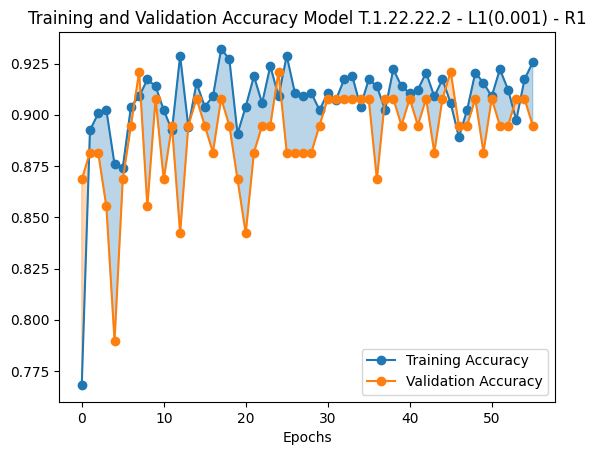

In [35]:
# Acurácia do Modelo

plt.figure()
plt.plot(acc_1, label='Training Accuracy', marker='o')
plt.plot(acc_val_1, label='Validation Accuracy', marker='o')
plt.fill_between(epochs_1, acc_1, acc_val_1, where=(acc_1 > acc_val_1), color='C0', alpha=0.3, interpolate=True)
plt.fill_between(epochs_1, acc_1, acc_val_1, where=(acc_1 < acc_val_1), color='C1', alpha=0.3, interpolate=True)
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy Model T.1.22.22.2 - L1(0.001) - R1')
plt.legend()
plt.savefig("/content/Downloads/Training and Validation Accuracy Model T.1.22.22.2 - L1(0.001) - R1.png"); # salvar a figura em pdf

# 3. Baixar a imagem
files.download("/content/Downloads/Training and Validation Accuracy Model T.1.22.22.2 - L1(0.001) - R1.png")


plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

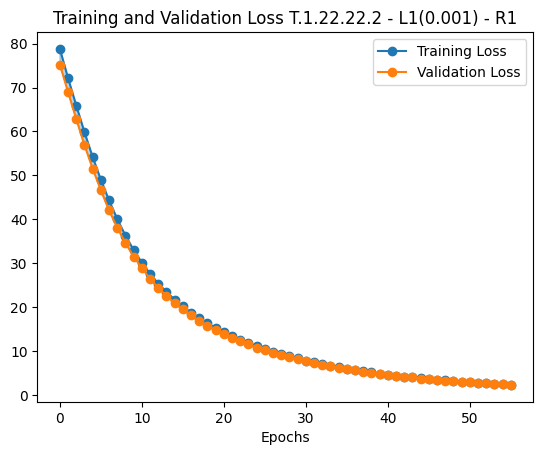

In [36]:
# Erro do Modelo

plt.figure()
plt.plot(loss_1, label='Training Loss', marker='o')
plt.plot(loss_val_1, label='Validation Loss', marker='o')
plt.fill_between(epochs_1, loss_1, loss_val_1, where=(loss_1 > loss_val_1), color='C0', alpha=0.3, interpolate=True)
plt.fill_between(epochs_1, loss_1, loss_val_1, where=(loss_1 < loss_val_1), color='C1', alpha=0.3, interpolate=True)
plt.xlabel('Epochs')
plt.title('Training and Validation Loss T.1.22.22.2 - L1(0.001) - R1')
plt.legend()
plt.savefig("/content/Downloads/Training and Validation Loss T.1.22.22.2 - L1(0.001) - R1.png"); # salvar a figura em pdf

# 3. Baixar a imagem
files.download("/content/Downloads/Training and Validation Loss T.1.22.22.2 - L1(0.001) - R1.png")

plt.show()

In [37]:
dataset_teste.class_indices

{'00R': 0, '01B': 1}

In [38]:
probabilidades_1 = network1.predict(dataset_teste)
probabilidades_1

75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


array([[0.29646382, 0.70353615],
       [0.77879053, 0.22120948],
       [0.33867577, 0.6613242 ],
       [0.89752316, 0.10247678],
       [0.84023064, 0.15976939],
       [0.9911718 , 0.00882822],
       [0.8427528 , 0.15724717],
       [0.9903798 , 0.0096202 ],
       [0.28795105, 0.71204895],
       [0.36253145, 0.6374686 ],
       [0.98775053, 0.01224945],
       [0.50132084, 0.4986791 ],
       [0.9959424 , 0.00405752],
       [0.52964956, 0.47035038],
       [0.996874  , 0.00312595],
       [0.9730217 , 0.02697834],
       [0.9978193 , 0.00218065],
       [0.99731714, 0.00268292],
       [0.36324632, 0.6367537 ],
       [0.9984799 , 0.00152012],
       [0.99578196, 0.00421795],
       [0.01236351, 0.98763645],
       [0.01341927, 0.9865807 ],
       [0.06316923, 0.9368308 ],
       [0.02490505, 0.9750949 ],
       [0.01815717, 0.9818429 ],
       [0.26546362, 0.73453647],
       [0.0502621 , 0.94973785],
       [0.01975761, 0.9802423 ],
       [0.150526  , 0.84947395],
       [0.

In [39]:
# índice da coluna com maior probabilidade
previsoes_1 = np.argmax(probabilidades_1, axis = 1) # - vetor com 0 ou 1 - escolhe a coluna do maior item no vetor

# vetor com as maiores probabilidades
prob_previsoes_1 = np.amax(probabilidades_1, axis=1) # - vetor com as maiores probabilidades

print("Previsões 1")
print(" ")
print(previsoes_1)

Previsões 1
 
[1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]


In [40]:
dataset_teste.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

# Avaliação do Modelo

In [41]:
# Evaluate the model
model_evaluation = network1.evaluate(dataset_teste)

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8049 - auc: 0.9332 - loss: 2.9326


# Matriz de Confusão

In [42]:
# Acurácia do Modelo

from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes_1)

0.92

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

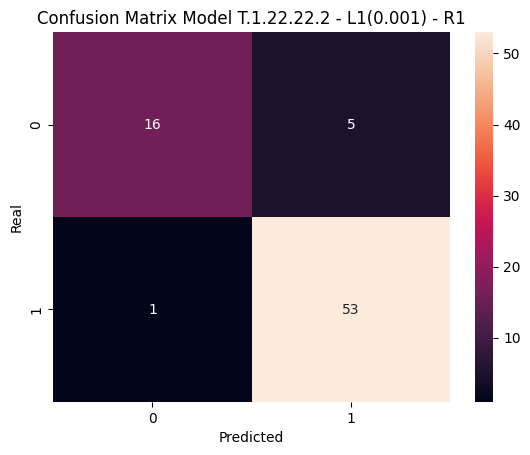

In [43]:
from sklearn.metrics import confusion_matrix
cm_1 = confusion_matrix(dataset_teste.classes, previsoes_1)

plt.figure()
plt.title('Confusion Matrix Model T.1.22.22.2 - L1(0.001) - R1')

sns.heatmap(cm_1, annot=True)

plt.xlabel('Predicted')
plt.ylabel('Real')

plt.savefig("/content/Downloads/Confusion Matrix Model T.1.22.22.2 - L1(0.001) - R1.png"); # salvar a figura em pdf

# 3. Baixar a imagem
files.download("/content/Downloads/Confusion Matrix Model T.1.22.22.2 - L1(0.001) - R1.png")

plt.show()

In [44]:
from sklearn.metrics import classification_report

print("RODADA 1")
print("")
print(classification_report(dataset_teste.classes, previsoes_1))
classification_report_rodada_1 = classification_report(dataset_teste.classes, previsoes_1)

# Salvar em .txt
file_name = "classification_report_rodada_1.txt"
with open(file_name, 'w') as file:
    file.write(classification_report_rodada_1)

# Baixar o arquivo
files.download(file_name)

RODADA 1

              precision    recall  f1-score   support

           0       0.94      0.76      0.84        21
           1       0.91      0.98      0.95        54

    accuracy                           0.92        75
   macro avg       0.93      0.87      0.89        75
weighted avg       0.92      0.92      0.92        75



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Estabelecendo os parametros para formar o AUC
fpr_1, tpr_1, thresholds_1 = roc_curve(dataset_teste.classes, previsoes_1)
roc_auc_1 = roc_auc_score(dataset_teste.classes, previsoes_1)

print(f'AUC: {roc_auc_1:.2f}')

AUC: 0.87


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

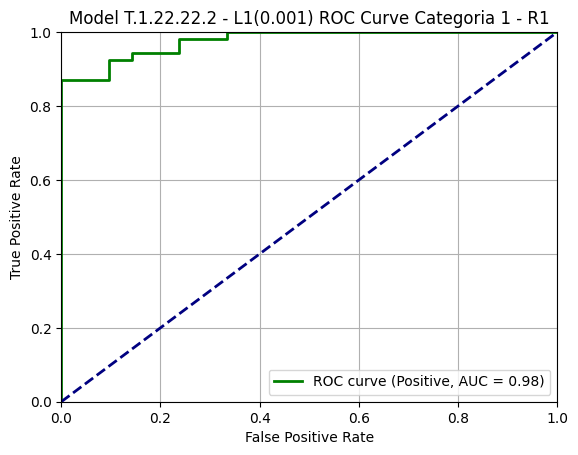

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

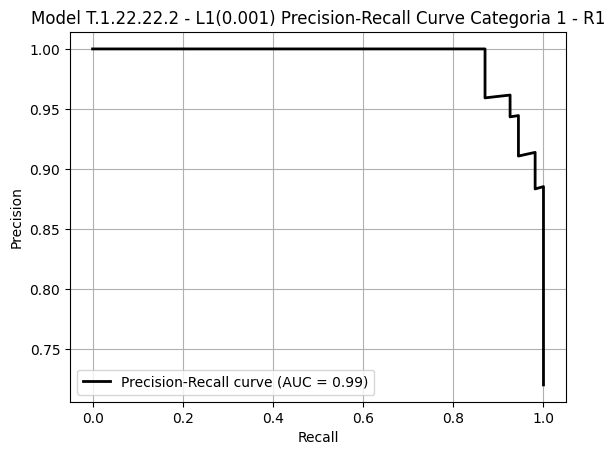

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

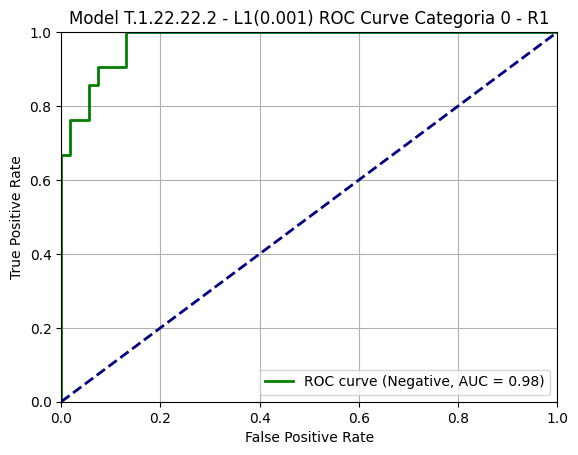

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

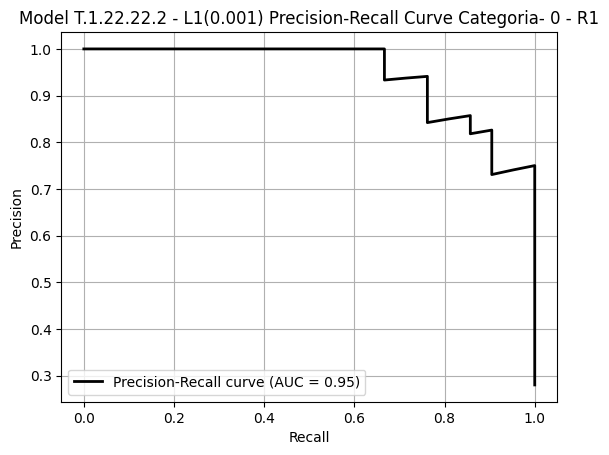

In [46]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Obter probabilidades previstas para ambas as classes
y_probas_positive_1 = probabilidades_1[:, 1]  # Probabilidades para a classe positiva
y_probas_negative_1 = probabilidades_1[:, 0]  # Probabilidades para a classe negativa

# Gerar e plotar a curva ROC para a classe positiva - 1
fpr_pos_1, tpr_pos_1, _ = roc_curve(dataset_teste.classes, y_probas_positive_1)
roc_auc_pos_1 = auc(fpr_pos_1, tpr_pos_1)
plt.figure()
plt.plot(fpr_pos_1, tpr_pos_1, color='green', lw=2, label=f'ROC curve (Positive, AUC = {roc_auc_pos_1:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # plotar a linha pontilhada de 50%
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 1 - R1')
plt.legend(loc="lower right")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 1 - R1.pdf"); # salvar a figura em png
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 1 - R1.pdf") # Baixar a imagem
plt.show()

# Gerar e plotar a curva Precision-Recall para a classe positiva - 1
precision_pos_1, recall_pos_1, _ = precision_recall_curve(dataset_teste.classes, y_probas_positive_1)
pr_auc_pos_1 = auc(recall_pos_1, precision_pos_1)
plt.figure()
plt.plot(recall_pos_1, precision_pos_1, color='black', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc_pos_1:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title('Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 1 - R1')
plt.legend(loc="lower left")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria - 1 - R1.pdf"); # salvar a figura em png
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria - 1 - R1.pdf") # Baixar a imagem
plt.show()

# Gerar e plotar a curva ROC para a classe negativa - 0
fpr_neg_1, tpr_neg_1, _ = roc_curve(1 - dataset_teste.classes, y_probas_negative_1)
roc_auc_neg_1 = auc(fpr_neg_1, tpr_neg_1)
plt.figure()
plt.plot(fpr_neg_1, tpr_neg_1, color='green', lw=2, label=f'ROC curve (Negative, AUC = {roc_auc_neg_1:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 0 - R1')
plt.legend(loc="lower right")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 0 - R1.pdf"); # salvar a figura em pdf
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 0 - R1.pdf") # Baixar a imagem
plt.show()

# Gerar e plotar a curva Precision-Recall para a classe negativa - 0
precision_neg_1, recall_neg_1, _ = precision_recall_curve(1 - dataset_teste.classes, y_probas_negative_1)
pr_auc_neg_1 = auc(recall_neg_1, precision_neg_1)
plt.figure()
plt.plot(recall_neg_1, precision_neg_1, color='black', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc_neg_1:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title('Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria- 0 - R1')
plt.legend(loc="lower left")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 0 - R1.pdf"); # salvar a figura em pdf
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 0 - R1.pdf") # Baixar a imagem
plt.show()

# Salvar a rede neural

In [47]:
model_json = network1.to_json()
with open('/content/Downloads/T.1.22.22.2_1.json','w') as json_file:
  json_file.write(model_json)


In [48]:
from keras.models import save_model

network_saved = save_model(network1, '/content/Downloads/weights_T.1.22.22.2_1.hdf5')

# Carregar a rede neural

In [49]:
# with open('T.1.22.22.2_1.json', 'r') as json_file:
#   json_saved_model = json_file.read()
# json_saved_model

In [50]:
# network_loaded = tf.keras.models.model_from_json(json_saved_model)
# network_loaded.load_weights('weights_T.1.22.22.2_1.hdf5')
# network_loaded.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4) , metrics=[tf.keras.metrics.AUC(curve='PR'), 'accuracy'])

##############################################################

##############################################################

# **Rodada 2**

## **Resetando a base de imagens**

In [51]:
# deletando os diretorios

import shutil

def delete_directory(directory_path):
  """Deletes a directory and its contents.

  Args:
    directory_path: The path to the directory to delete.
  """
  try:
    shutil.rmtree(directory_path)
    print(f"Directory '{directory_path}' deleted successfully.")
  except FileNotFoundError:
    print(f"Directory '{directory_path}' not found.")
  except OSError as e:
    print(f"Error deleting directory '{directory_path}': {e}")

# Example usage:
delete_directory("/content/test")
delete_directory("/content/train")
delete_directory("/content/validation")
delete_directory("/content/Base_2_Classes_B_R")

Directory '/content/test' deleted successfully.
Directory '/content/train' deleted successfully.
Directory '/content/validation' deleted successfully.
Directory '/content/Base_2_Classes_B_R' deleted successfully.


## Subindo o arquivo zipado com as imagens

In [52]:
!unzip -q Base_2_Classes_B_R.zip
!ls

Base_2_Classes_B_R	classification_report_rodada_1.txt  sample_data
Base_2_Classes_B_R.zip	Downloads


In [53]:
!ls Base_2_Classes_B_R

00R  01B


In [54]:
import os

# Todas as categorias
num_skipped = 0
for folder_name in ("00R", "01B"): # descrevendo as pastas presentes dentro do arquivo main "Base"
    folder_path = os.path.join("Base_2_Classes_B_R", folder_name) # juntando o caminho de cada uma das pastas com o caminho da main pasta
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) # estabelecendo o caminho completo de cada imagem dentro da pasta main e subpastas
        try:
            fobj = open(fpath, "rb") # lendo e abrindo cada uma das imagens
            is_pfif = tf.compat.as_bytes("PFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.png'
            # (T.1.0.3.1)
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.jpg'
            #
        finally:
            fobj.close()

print("Deletadas %d imagens" % num_skipped)

Deletadas 0 imagens


# Gerando os Datasets de treino, teste e validação randomicamente

In [55]:
import os
import random
from shutil import copyfile

# Diretório original das imagens
original_dataset_dir = '/content/Base_2_Classes_B_R'

# Diretório de destino para os conjuntos de treinamento, teste e validação
base_dir = '/content'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

val_dir = os.path.join(base_dir, 'validation')
os.makedirs(val_dir, exist_ok=True)

# Lista de classes (subdiretórios) no diretório original
classes = os.listdir(original_dataset_dir)

# Defina as proporções de imagens para treinamento (80%), teste (10%) e validação (10%)
train_split = 0.8
test_split = 0.1

# Itera sobre cada classe para criar os conjuntos de treinamento, teste e validação
for class_name in classes:
    class_dir = os.path.join(original_dataset_dir, class_name)

    # Lista de todas as imagens na classe
    images = os.listdir(class_dir)

    # Embaralha a lista de imagens para dividir aleatoriamente
    random.shuffle(images)

    # Calcula os índices para dividir entre treinamento, teste e validação
    train_index = int(len(images) * train_split)
    test_index = train_index + int(len(images) * test_split)

    # Lista de imagens para treinamento, teste e validação
    train_images = images[:train_index]
    test_images = images[train_index:test_index]
    val_images = images[test_index:]

    # Cria os subdiretórios de treinamento, teste e validação para a classe
    train_class_dir = os.path.join(train_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)

    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(test_class_dir, exist_ok=True)

    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(val_class_dir, exist_ok=True)

    # Copia as imagens para os diretórios de treinamento, teste e validação
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_class_dir, img)
        copyfile(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_class_dir, img)
        copyfile(src, dst)

    for img in val_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(val_class_dir, img)
        copyfile(src, dst)

print('Feito!')


Feito!


# Dataset Treino + Data Augmentation

In [56]:
gerador_treinamento = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input,
                                        #Data Augmentation
                                        zoom_range=0.2,
                                        rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

dataset_treinamento = gerador_treinamento.flow_from_directory('/content/train',
                                                              target_size=(224,224),
                                                              color_mode = 'rgb',
                                                              batch_size=16,
                                                              class_mode='categorical',
                                                              shuffle = True) # as imagens do dataset serão embaralhadas antes de cada época

Found 604 images belonging to 2 classes.


In [57]:
dataset_treinamento.class_indices

{'00R': 0, '01B': 1}

In [58]:
dataset_treinamento.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Dataset Validação

In [59]:
gerador_validacao = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

dataset_validacao = gerador_validacao.flow_from_directory('/content/validation',
                                                              target_size=(224,224),
                                                              color_mode = 'rgb',
                                                              batch_size=16,
                                                              class_mode='categorical',
                                                              shuffle = False) # as imagens do dataset NÃO serão embaralhadas antes de cada época na validação. É um teste do modelo depois de cada época

Found 76 images belonging to 2 classes.


# Dataset Teste

In [60]:
gerador_teste = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

dataset_teste = gerador_teste.flow_from_directory('/content/test',
                                                  target_size=(224,224),
                                                  color_mode = 'rgb',
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 75 images belonging to 2 classes.


# Rede neural pré-treinada
- Documentação: https://keras.io/api/applications/


## VGG-19

In [61]:
# modelo_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

## ResNet50

In [62]:
modelo_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

## ResNet101

In [63]:
# modelo_base = tf.keras.applications.ResNet101(weights='imagenet', include_top=False)

## ResNet152V2

In [64]:
# modelo_base = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False)

In [65]:
modelo_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [66]:
len(modelo_base.layers)

175

In [67]:
for layer in modelo_base.layers:
  #print(layer)
  layer.trainable = False

In [68]:
for layer in modelo_base.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer_1, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True>

# Camada densa personalizada

In [69]:
modelo_base.output

<KerasTensor shape=(None, None, None, 2048), dtype=float32, sparse=False, ragged=False, name=keras_tensor_354>

In [70]:
from functools import partial

RegularizadedDense = partial(keras.layers.Dense,
                             activation = "elu",
                             kernel_initializer = "he_normal",
                             kernel_regularizer = keras.regularizers.L1(0.001))

head_model = modelo_base.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = RegularizadedDense(1029)(head_model)
head_model = RegularizadedDense(514)(head_model)
head_model = RegularizadedDense(257)(head_model)
head_model = RegularizadedDense(units=2, activation='softmax')(head_model) # Função de ativação = "softmax" para ver a probabilidade entre as duas classes

print('Feito!')

Feito!


# Construção e treinamento da rede neural

In [71]:
modelo_base.input

<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_180>

In [72]:
network2 = Model(inputs = modelo_base.input, outputs = head_model)

In [73]:
for layer in network2.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer_1, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True>

In [74]:
network2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 26,358,424 (100.55 MB)

 Trainable params: 2,770,712 (10.57 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Compilando o Modelo

In [75]:
# Compilar o modelo
network2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4), loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(curve='PR'), 'accuracy'])  # AUC da curva Precision-Recall

# Definir o callback de Early Stopping para inicio apos 50 epocas
early_stopping_2 = EarlyStopping(monitor='val_auc_1', patience=5, mode='max', min_delta=0.001, verbose=1, baseline=None, restore_best_weights=True, start_from_epoch=50)

print("Feito")

Feito


In [76]:
# Treinamento
history_2 = network2.fit(dataset_treinamento, epochs=100, validation_data=dataset_validacao, callbacks=[early_stopping_2])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 532ms/step - accuracy: 0.7419 - auc_1: 0.7751 - loss: 79.5371 - val_accuracy: 0.8421 - val_auc_1: 0.9377 - val_loss: 73.8357
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.8690 - auc_1: 0.9312 - loss: 71.9977 - val_accuracy: 0.8684 - val_auc_1: 0.9530 - val_loss: 66.4485
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.8845 - auc_1: 0.9454 - loss: 64.6626 - val_accuracy: 0.8684 - val_auc_1: 0.9622 - val_loss: 59.3877
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.9029 - auc_1: 0.9628 - loss: 57.6924 - val_accuracy: 0.8684 - val_auc_1: 0.9699 - val_loss: 52.8292
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.8841 - auc_1: 0.9551 - loss: 51.3428 - val_accuracy: 0.8553 - val_auc_1: 0.9721 - val_loss: 46.9221
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.8947 - auc_1: 0.9562 - loss: 45.6172 - val_accuracy: 0.8684 - val_auc_1: 0.9720 - val_loss: 

# Avaliação da rede neural

In [77]:
history_2.history.keys()

dict_keys(['accuracy', 'auc_1', 'loss', 'val_accuracy', 'val_auc_1', 'val_loss'])

In [78]:
# Estabelecendo os parâmetros para plotagem
loss_2 = np.array(history_2.history['loss'])
loss_val_2 = np.array(history_2.history['val_loss'])

acc_2 = np.array(history_2.history['accuracy'])
acc_val_2 = np.array(history_2.history['val_accuracy'])

epochs_2 = range(len(history_2.history['loss']))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

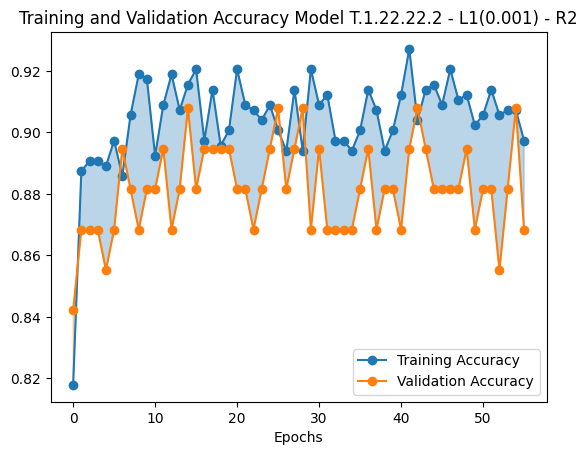

In [79]:
# Acurácia do Modelo

plt.figure()
plt.plot(acc_2, label='Training Accuracy', marker='o')
plt.plot(acc_val_2, label='Validation Accuracy', marker='o')
plt.fill_between(epochs_2, acc_2, acc_val_2, where=(acc_2 > acc_val_2), color='C0', alpha=0.3, interpolate=True)
plt.fill_between(epochs_2, acc_2, acc_val_2, where=(acc_2 < acc_val_2), color='C1', alpha=0.3, interpolate=True)
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy Model T.1.22.22.2 - L1(0.001) - R2')
plt.legend()
plt.savefig("/content/Downloads/Training and Validation Accuracy Model T.1.22.22.2 - L1(0.001) - R2.png"); # salvar a figura em pdf
files.download("/content/Downloads/Training and Validation Accuracy Model T.1.22.22.2 - L1(0.001) - R2.png") # Baixar a imagem


plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

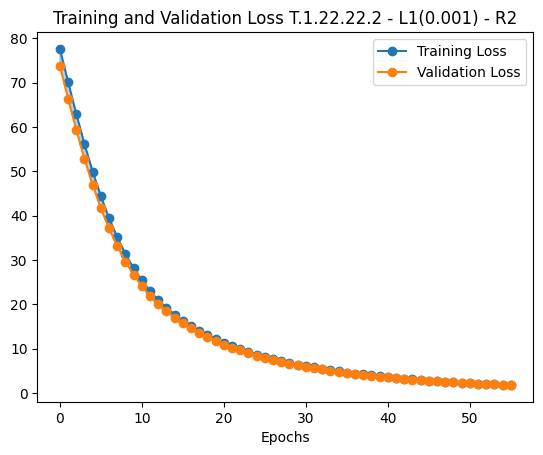

In [80]:
# Erro do Modelo

plt.figure()
plt.plot(loss_2, label='Training Loss', marker='o')
plt.plot(loss_val_2, label='Validation Loss', marker='o')
plt.fill_between(epochs_2, loss_2, loss_val_2, where=(loss_2 > loss_val_2), color='C0', alpha=0.3, interpolate=True)
plt.fill_between(epochs_2, loss_2, loss_val_2, where=(loss_2 < loss_val_2), color='C1', alpha=0.3, interpolate=True)
plt.xlabel('Epochs')
plt.title('Training and Validation Loss T.1.22.22.2 - L1(0.001) - R2')
plt.legend()
plt.savefig("/content/Downloads/Training and Validation Loss T.1.22.22.2 - L1(0.001) - R2.png"); # salvar a figura em pdf
files.download("/content/Downloads/Training and Validation Loss T.1.22.22.2 - L1(0.001) - R2.png") # Baixar a imagem

plt.show()

In [81]:
dataset_teste.class_indices

{'00R': 0, '01B': 1}

In [82]:
probabilidades_2 = network2.predict(dataset_teste)
probabilidades_2

75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


array([[0.9724807 , 0.02751924],
       [0.21429875, 0.7857012 ],
       [0.97472996, 0.02527001],
       [0.98189586, 0.01810423],
       [0.15430059, 0.84569937],
       [0.9742579 , 0.02574208],
       [0.97297454, 0.02702547],
       [0.9912521 , 0.00874785],
       [0.48809844, 0.51190156],
       [0.32115355, 0.6788464 ],
       [0.4503784 , 0.5496216 ],
       [0.9663744 , 0.03362561],
       [0.09704491, 0.90295506],
       [0.97191364, 0.02808638],
       [0.98692846, 0.01307156],
       [0.9786521 , 0.02134789],
       [0.9701452 , 0.02985483],
       [0.98876905, 0.01123093],
       [0.99287874, 0.00712122],
       [0.33590516, 0.6640948 ],
       [0.9830927 , 0.01690728],
       [0.02763842, 0.97236156],
       [0.02142954, 0.9785704 ],
       [0.01085324, 0.9891467 ],
       [0.02340661, 0.9765934 ],
       [0.01077439, 0.98922557],
       [0.01305008, 0.98694986],
       [0.04130166, 0.9586984 ],
       [0.008041  , 0.991959  ],
       [0.01048411, 0.9895159 ],
       [0.

In [83]:
# índice da coluna com maior probabilidade
previsoes_2 = np.argmax(probabilidades_2, axis = 1) # - vetor com 0 ou 1 - escolhe a coluna do maior item no vetor

# vetor com as maiores probabilidades
prob_previsoes_2 = np.amax(probabilidades_2, axis=1) # - vetor com as maiores probabilidades

print("Previsões 2")
print(" ")
print(previsoes_2)

Previsões 2
 
[0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1]


In [84]:
dataset_teste.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

# Avaliação do Modelo

In [85]:
# Evaluate the model
model_evaluation = network2.evaluate(dataset_teste)

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7850 - auc_1: 0.9475 - loss: 2.2408


# Matriz de Confusão

In [86]:
# Acurácia do Modelo

from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes_2)

0.88

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

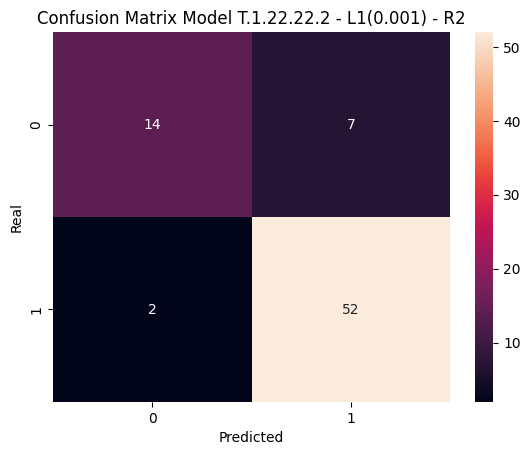

In [87]:
from sklearn.metrics import confusion_matrix
cm_2 = confusion_matrix(dataset_teste.classes, previsoes_2)

plt.figure()
plt.title('Confusion Matrix Model T.1.22.22.2 - L1(0.001) - R2')

sns.heatmap(cm_2, annot=True)

plt.xlabel('Predicted')
plt.ylabel('Real')

plt.savefig("/content/Downloads/Confusion Matrix Model T.1.22.22.2 - L1(0.001) - R2.png"); # salvar a figura em pdf
files.download("/content/Downloads/Confusion Matrix Model T.1.22.22.2 - L1(0.001) - R2.png") # Baixar a imagem

plt.show()

In [88]:
from sklearn.metrics import classification_report
print("RODADA 2")
print("")
print(classification_report(dataset_teste.classes, previsoes_2))
classification_report_rodada_2 = classification_report(dataset_teste.classes, previsoes_2)

# Salvar em .txt
file_name = "classification_report_rodada_2.txt"
with open(file_name, 'w') as file:
    file.write(classification_report_rodada_2)

# Baixar o arquivo
files.download(file_name)

RODADA 2

              precision    recall  f1-score   support

           0       0.88      0.67      0.76        21
           1       0.88      0.96      0.92        54

    accuracy                           0.88        75
   macro avg       0.88      0.81      0.84        75
weighted avg       0.88      0.88      0.87        75



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [89]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Estabelecendo os parametros para formar o AUC
fpr_2, tpr_2, thresholds_2 = roc_curve(dataset_teste.classes, previsoes_2)
roc_auc_2 = roc_auc_score(dataset_teste.classes, previsoes_2)

print(f'AUC: {roc_auc_2:.2f}')

AUC: 0.81


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

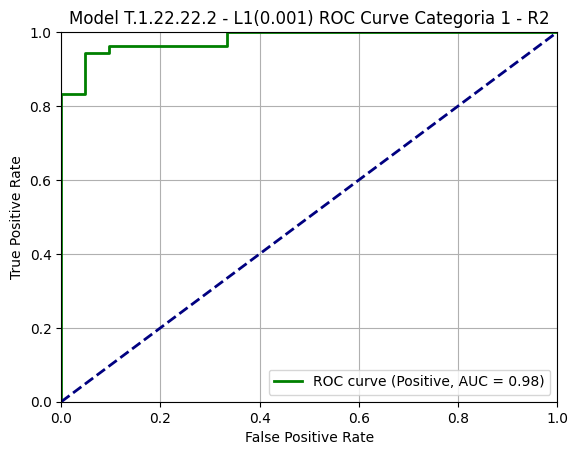

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

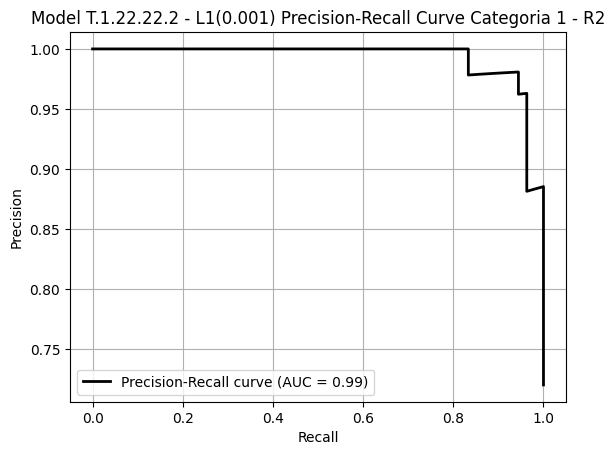

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

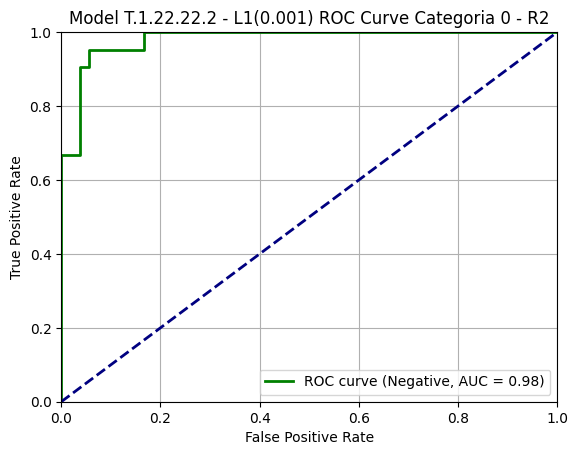

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

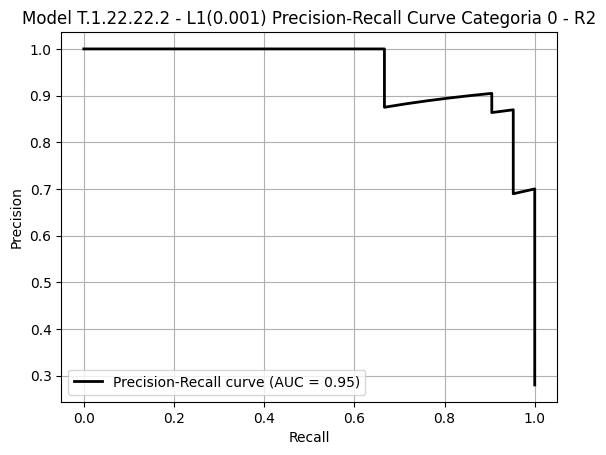

In [90]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Obter probabilidades previstas para ambas as classes
y_probas_positive_2 = probabilidades_2[:, 1]  # Probabilidades para a classe positiva
y_probas_negative_2 = probabilidades_2[:, 0]  # Probabilidades para a classe negativa

# Gerar e plotar a curva ROC para a classe positiva - 1
fpr_pos_2, tpr_pos_2, _ = roc_curve(dataset_teste.classes, y_probas_positive_2)
roc_auc_pos_2 = auc(fpr_pos_2, tpr_pos_2)
plt.figure()
plt.plot(fpr_pos_2, tpr_pos_2, color='green', lw=2, label=f'ROC curve (Positive, AUC = {roc_auc_pos_2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # plotar a linha pontilhada de 50%
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 1 - R2')
plt.legend(loc="lower right")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 1 - R2.pdf"); # salvar a figura em png
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 1 - R2.pdf") # Baixar a imagem
plt.show()

# Gerar e plotar a curva Precision-Recall para a classe positiva - 1
precision_pos_2, recall_pos_2, _ = precision_recall_curve(dataset_teste.classes, y_probas_positive_2)
pr_auc_pos_2 = auc(recall_pos_2, precision_pos_2)
plt.figure()
plt.plot(recall_pos_2, precision_pos_2, color='black', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc_pos_2:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title('Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 1 - R2')
plt.legend(loc="lower left")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 1- R2.pdf"); # salvar a figura em png
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 1- R2.pdf") # Baixar a imagem
plt.show()

# Gerar e plotar a curva ROC para a classe negativa - 0
fpr_neg_2, tpr_neg_2, _ = roc_curve(1 - dataset_teste.classes, y_probas_negative_2)
roc_auc_neg_2 = auc(fpr_neg_2, tpr_neg_2)
plt.figure()
plt.plot(fpr_neg_2, tpr_neg_2, color='green', lw=2, label=f'ROC curve (Negative, AUC = {roc_auc_neg_2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 0 - R2')
plt.legend(loc="lower right")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 0 - R2.pdf"); # salvar a figura em pdf
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 0 - R2.pdf") # Baixar a imagem
plt.show()

# Gerar e plotar a curva Precision-Recall para a classe negativa - 0
precision_neg_2, recall_neg_2, _ = precision_recall_curve(1 - dataset_teste.classes, y_probas_negative_2)
pr_auc_neg_2 = auc(recall_neg_2, precision_neg_2)
plt.figure()
plt.plot(recall_neg_2, precision_neg_2, color='black', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc_neg_2:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title('Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 0 - R2')
plt.legend(loc="lower left")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 0 - R2.pdf"); # salvar a figura em pdf
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 0 - R2.pdf") # Baixar a imagem
plt.show()

# Salvar a rede neural

In [91]:
model_json = network2.to_json()
with open('/content/Downloads/T.1.22.22.2_2.json','w') as json_file:
  json_file.write(model_json)


In [92]:
from keras.models import save_model

network_saved = save_model(network2, '/content/Downloads/weights_T.1.22.22.2_2.hdf5')

# Carregar a rede neural

In [93]:
# with open('T.1.22.22.2_2.json', 'r') as json_file:
#   json_saved_model = json_file.read()
# json_saved_model

In [94]:
# network_loaded = tf.keras.models.model_from_json(json_saved_model)
# network_loaded.load_weights('weights_T.1.22.22.2_2.hdf5')
# network_loaded.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4) , metrics=[tf.keras.metrics.AUC(curve='PR'), 'accuracy'])

##############################################################################
##############################################################################

## **Rodada 3**

## **Resetando a base de imagens**

In [95]:
# deletando os diretorios

import shutil

def delete_directory(directory_path):
  """Deletes a directory and its contents.

  Args:
    directory_path: The path to the directory to delete.
  """
  try:
    shutil.rmtree(directory_path)
    print(f"Directory '{directory_path}' deleted successfully.")
  except FileNotFoundError:
    print(f"Directory '{directory_path}' not found.")
  except OSError as e:
    print(f"Error deleting directory '{directory_path}': {e}")

# Example usage:
delete_directory("/content/test")
delete_directory("/content/train")
delete_directory("/content/validation")
delete_directory("/content/Base_2_Classes_B_R")

Directory '/content/test' deleted successfully.
Directory '/content/train' deleted successfully.
Directory '/content/validation' deleted successfully.
Directory '/content/Base_2_Classes_B_R' deleted successfully.


## Subindo o arquivo zipado com as imagens

In [96]:
!unzip -q Base_2_Classes_B_R.zip
!ls

Base_2_Classes_B_R	classification_report_rodada_1.txt  Downloads
Base_2_Classes_B_R.zip	classification_report_rodada_2.txt  sample_data


In [97]:
!ls Base_2_Classes_B_R

00R  01B


In [98]:
import os

# Todas as categorias
num_skipped = 0
for folder_name in ("00R", "01B"): # descrevendo as pastas presentes dentro do arquivo main "Base"
    folder_path = os.path.join("Base_2_Classes_B_R", folder_name) # juntando o caminho de cada uma das pastas com o caminho da main pasta
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) # estabelecendo o caminho completo de cada imagem dentro da pasta main e subpastas
        try:
            fobj = open(fpath, "rb") # lendo e abrindo cada uma das imagens
            is_pfif = tf.compat.as_bytes("PFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.png'
            # (T.1.0.3.1)
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.jpg'
            #
        finally:
            fobj.close()

print("Deletadas %d imagens" % num_skipped)

Deletadas 0 imagens


# Gerando os Datasets de treino, teste e validação randomicamente

In [99]:
import os
import random
from shutil import copyfile

# Diretório original das imagens
original_dataset_dir = '/content/Base_2_Classes_B_R'

# Diretório de destino para os conjuntos de treinamento, teste e validação
base_dir = '/content'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

val_dir = os.path.join(base_dir, 'validation')
os.makedirs(val_dir, exist_ok=True)

# Lista de classes (subdiretórios) no diretório original
classes = os.listdir(original_dataset_dir)

# Defina as proporções de imagens para treinamento (80%), teste (10%) e validação (10%)
train_split = 0.8
test_split = 0.1

# Itera sobre cada classe para criar os conjuntos de treinamento, teste e validação
for class_name in classes:
    class_dir = os.path.join(original_dataset_dir, class_name)

    # Lista de todas as imagens na classe
    images = os.listdir(class_dir)

    # Embaralha a lista de imagens para dividir aleatoriamente
    random.shuffle(images)

    # Calcula os índices para dividir entre treinamento, teste e validação
    train_index = int(len(images) * train_split)
    test_index = train_index + int(len(images) * test_split)

    # Lista de imagens para treinamento, teste e validação
    train_images = images[:train_index]
    test_images = images[train_index:test_index]
    val_images = images[test_index:]

    # Cria os subdiretórios de treinamento, teste e validação para a classe
    train_class_dir = os.path.join(train_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)

    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(test_class_dir, exist_ok=True)

    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(val_class_dir, exist_ok=True)

    # Copia as imagens para os diretórios de treinamento, teste e validação
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_class_dir, img)
        copyfile(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_class_dir, img)
        copyfile(src, dst)

    for img in val_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(val_class_dir, img)
        copyfile(src, dst)

print('Feito!')


Feito!


# Dataset Treino + Data Augmentation

In [100]:
gerador_treinamento = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input,
                                        #Data Augmentation
                                        zoom_range=0.2,
                                        rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

dataset_treinamento = gerador_treinamento.flow_from_directory('/content/train',
                                                              target_size=(224,224),
                                                              color_mode = 'rgb',
                                                              batch_size=16,
                                                              class_mode='categorical',
                                                              shuffle = True) # as imagens do dataset serão embaralhadas antes de cada época

Found 604 images belonging to 2 classes.


In [101]:
dataset_treinamento.class_indices

{'00R': 0, '01B': 1}

In [102]:
dataset_treinamento.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Dataset Validação

In [103]:
gerador_validacao = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

dataset_validacao = gerador_validacao.flow_from_directory('/content/validation',
                                                              target_size=(224,224),
                                                              color_mode = 'rgb',
                                                              batch_size=16,
                                                              class_mode='categorical',
                                                              shuffle = False) # as imagens do dataset NÃO serão embaralhadas antes de cada época na validação. É um teste do modelo depois de cada época

Found 76 images belonging to 2 classes.


# Dataset Teste

In [104]:
gerador_teste = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

dataset_teste = gerador_teste.flow_from_directory('/content/test',
                                                  target_size=(224,224),
                                                  color_mode = 'rgb',
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 75 images belonging to 2 classes.


# Rede neural pré-treinada
- Documentação: https://keras.io/api/applications/


## VGG-19

In [105]:
# modelo_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

## ResNet50

In [106]:
modelo_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

## ResNet101

In [107]:
# modelo_base = tf.keras.applications.ResNet101(weights='imagenet', include_top=False)

## ResNet152V2

In [108]:
# modelo_base = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False)

In [109]:
modelo_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [110]:
len(modelo_base.layers)

175

In [111]:
for layer in modelo_base.layers:
  #print(layer)
  layer.trainable = False

In [112]:
for layer in modelo_base.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer_2, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True>

# Camada densa personalizada

In [113]:
modelo_base.output

<KerasTensor shape=(None, None, None, 2048), dtype=float32, sparse=False, ragged=False, name=keras_tensor_534>

In [114]:
from functools import partial

RegularizadedDense = partial(keras.layers.Dense,
                             activation = "elu",
                             kernel_initializer = "he_normal",
                             kernel_regularizer = keras.regularizers.L1(0.001))

head_model = modelo_base.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = RegularizadedDense(1029)(head_model)
head_model = RegularizadedDense(514)(head_model)
head_model = RegularizadedDense(257)(head_model)
head_model = RegularizadedDense(units=2, activation='softmax')(head_model) # Função de ativação = "softmax" para ver a probabilidade entre as duas classes

print('Feito!')

Feito!


# Construção e treinamento da rede neural

In [115]:
modelo_base.input

<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_360>

In [116]:
network3 = Model(inputs = modelo_base.input, outputs = head_model)

In [117]:
for layer in network3.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer_2, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True>

In [118]:
network3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 26,358,424 (100.55 MB)

 Trainable params: 2,770,712 (10.57 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Compilando o Modelo

In [119]:
# Compilar o modelo
network3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4), loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(curve='PR'), 'accuracy'])  # AUC da curva Precision-Recall

# Definir o callback de Early Stopping para inicio apos 50 epocas
early_stopping_3 = EarlyStopping(monitor='val_auc_2', patience=5, mode='max', min_delta=0.001, verbose=1, baseline=None, restore_best_weights=True, start_from_epoch=50)

print("Feito")

Feito


In [120]:
# Treinamento
history_3 = network3.fit(dataset_treinamento, epochs=100, validation_data=dataset_validacao, callbacks=[early_stopping_3])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 550ms/step - accuracy: 0.7007 - auc_2: 0.7795 - loss: 79.6586 - val_accuracy: 0.8947 - val_auc_2: 0.9641 - val_loss: 74.4283
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.8552 - auc_2: 0.9393 - loss: 72.8041 - val_accuracy: 0.8816 - val_auc_2: 0.9713 - val_loss: 67.7456
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.8647 - auc_2: 0.9256 - loss: 66.2277 - val_accuracy: 0.9079 - val_auc_2: 0.9808 - val_loss: 61.2996
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.8828 - auc_2: 0.9558 - loss: 59.8337 - val_accuracy: 0.8947 - val_auc_2: 0.9677 - val_loss: 55.3115
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.9063 - auc_2: 0.9591 - loss: 53.9257 - val_accuracy: 0.9079 - val_auc_2: 0.9747 - val_loss: 49.8062
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.9073 - auc_2: 0.9585 - loss: 48.5695 - val_accuracy: 0.8947 - val_auc_2: 0.9796 - val_loss: 

# Avaliação da rede neural

In [121]:
history_3.history.keys()

dict_keys(['accuracy', 'auc_2', 'loss', 'val_accuracy', 'val_auc_2', 'val_loss'])

In [122]:
# Estabelecendo os parâmetros para plotagem
loss_3 = np.array(history_3.history['loss'])
loss_val_3 = np.array(history_3.history['val_loss'])

acc_3 = np.array(history_3.history['accuracy'])
acc_val_3 = np.array(history_3.history['val_accuracy'])

epochs_3 = range(len(history_3.history['loss']))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

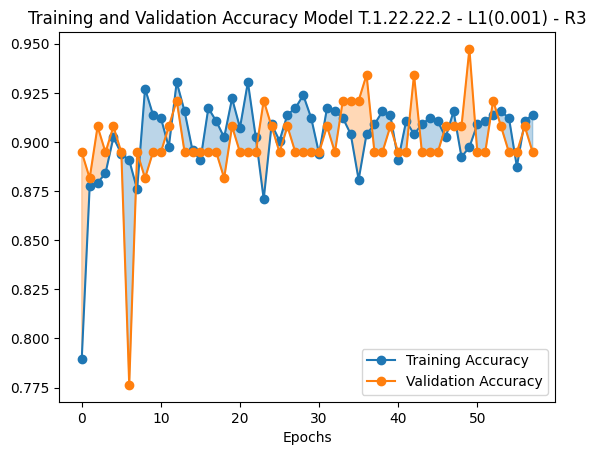

In [123]:
# Acurácia do Modelo

plt.figure()
plt.plot(acc_3, label='Training Accuracy', marker='o')
plt.plot(acc_val_3, label='Validation Accuracy', marker='o')
plt.fill_between(epochs_3, acc_3, acc_val_3, where=(acc_3 > acc_val_3), color='C0', alpha=0.3, interpolate=True)
plt.fill_between(epochs_3, acc_3, acc_val_3, where=(acc_3 < acc_val_3), color='C1', alpha=0.3, interpolate=True)
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy Model T.1.22.22.2 - L1(0.001) - R3')
plt.legend()
plt.savefig("/content/Downloads/Training and Validation Accuracy Model T.1.22.22.2 - L1(0.001) - R3.png"); # salvar a figura em pdf
files.download("/content/Downloads/Training and Validation Accuracy Model T.1.22.22.2 - L1(0.001) - R3.png") # Baixar a imagem

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

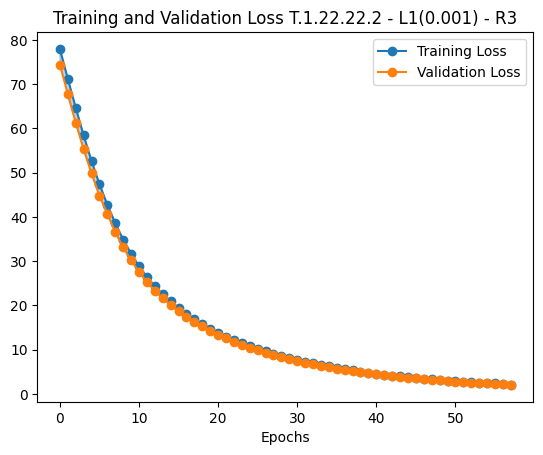

In [124]:
# Erro do Modelo

plt.figure()
plt.plot(loss_3, label='Training Loss', marker='o')
plt.plot(loss_val_3, label='Validation Loss', marker='o')
plt.fill_between(epochs_3, loss_3, loss_val_3, where=(loss_3 > loss_val_3), color='C0', alpha=0.3, interpolate=True)
plt.fill_between(epochs_3, loss_3, loss_val_3, where=(loss_3 < loss_val_3), color='C1', alpha=0.3, interpolate=True)
plt.xlabel('Epochs')
plt.title('Training and Validation Loss T.1.22.22.2 - L1(0.001) - R3')
plt.legend()
plt.savefig("/content/Downloads/Training and Validation Loss T.1.22.22.2 - L1(0.001) - R3.png"); # salvar a figura em pdf
files.download("/content/Downloads/Training and Validation Loss T.1.22.22.2 - L1(0.001) - R3.png") # Baixar a imagem

plt.show()

In [125]:
dataset_teste.class_indices

{'00R': 0, '01B': 1}

In [126]:
probabilidades_3 = network3.predict(dataset_teste)
probabilidades_3

75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


array([[9.66548979e-01, 3.34510244e-02],
       [2.67425001e-01, 7.32574999e-01],
       [8.57095540e-01, 1.42904446e-01],
       [9.98630702e-01, 1.36925885e-03],
       [8.15292835e-01, 1.84707150e-01],
       [5.39830565e-01, 4.60169464e-01],
       [9.90210772e-01, 9.78930574e-03],
       [9.58539248e-01, 4.14607786e-02],
       [9.97537613e-01, 2.46234029e-03],
       [9.99028683e-01, 9.71371192e-04],
       [3.20905358e-01, 6.79094613e-01],
       [9.85901356e-01, 1.40985856e-02],
       [7.35497117e-01, 2.64502883e-01],
       [3.28856736e-01, 6.71143234e-01],
       [9.89497423e-01, 1.05025256e-02],
       [9.96494353e-01, 3.50569165e-03],
       [9.95320022e-01, 4.67993878e-03],
       [9.93844211e-01, 6.15571253e-03],
       [9.95829523e-01, 4.17043595e-03],
       [9.93124187e-01, 6.87589031e-03],
       [9.96316314e-01, 3.68368183e-03],
       [2.65824944e-02, 9.73417461e-01],
       [6.00350508e-03, 9.93996501e-01],
       [4.10511494e-02, 9.58948851e-01],
       [2.178614

In [127]:
# índice da coluna com maior probabilidade
previsoes_3 = np.argmax(probabilidades_3, axis = 1) # - vetor com 0 ou 1 - escolhe a coluna do maior item no vetor

# vetor com as maiores probabilidades
prob_previsoes_3 = np.amax(probabilidades_3, axis=1) # - vetor com as maiores probabilidades

print("Previsões 3")
print(" ")
print(previsoes_3)

Previsões 3
 
[0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1]


In [128]:
dataset_teste.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

# Avaliação do Modelo

In [129]:
# Evaluate the model
model_evaluation = network3.evaluate(dataset_teste)

75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8964 - auc_2: 0.9756 - loss: 2.5332


# Matriz de Confusão

In [130]:
# Acurácia do Modelo

from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes_3)

0.9333333333333333

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

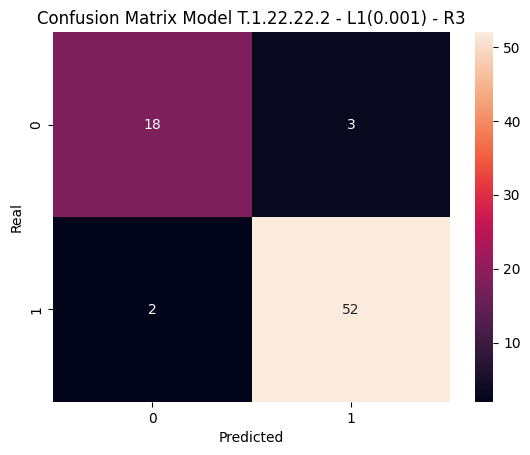

In [131]:
from sklearn.metrics import confusion_matrix
cm_3 = confusion_matrix(dataset_teste.classes, previsoes_3)

plt.figure()
plt.title('Confusion Matrix Model T.1.22.22.2 - L1(0.001) - R3')

sns.heatmap(cm_3, annot=True)

plt.xlabel('Predicted')
plt.ylabel('Real')

plt.savefig("/content/Downloads/Confusion Matrix Model T.1.22.22.2 - L1(0.001) - R3.png"); # salvar a figura em pdf
files.download("/content/Downloads/Confusion Matrix Model T.1.22.22.2 - L1(0.001) - R3.png") # Baixar a imagem

plt.show()

In [132]:
from sklearn.metrics import classification_report
print("RODADA 3")
print("")
print(classification_report(dataset_teste.classes, previsoes_3))
classification_report_rodada_3 = classification_report(dataset_teste.classes, previsoes_3)

# Salvar em .txt
file_name = "classification_report_rodada_3.txt"
with open(file_name, 'w') as file:
    file.write(classification_report_rodada_3)

# Baixar o arquivo
files.download(file_name)

RODADA 3

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.95      0.96      0.95        54

    accuracy                           0.93        75
   macro avg       0.92      0.91      0.92        75
weighted avg       0.93      0.93      0.93        75



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [133]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Estabelecendo os parametros para formar o AUC
fpr_3, tpr_3, thresholds_3 = roc_curve(dataset_teste.classes, previsoes_3)
roc_auc_3 = roc_auc_score(dataset_teste.classes, previsoes_3)

print(f'AUC: {roc_auc_3:.2f}')

AUC: 0.91


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

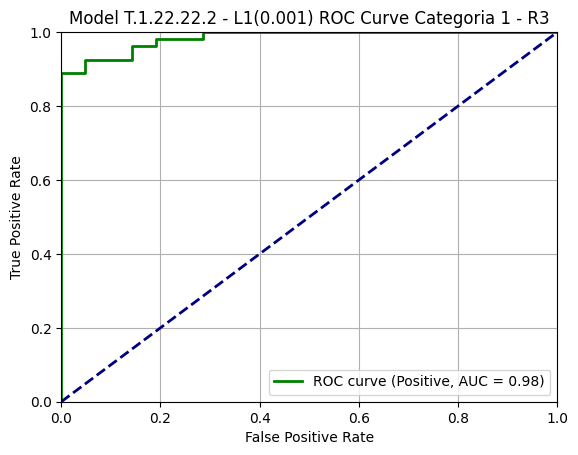

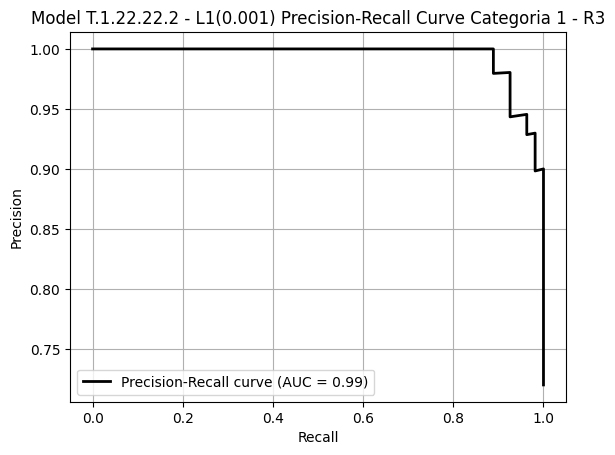

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

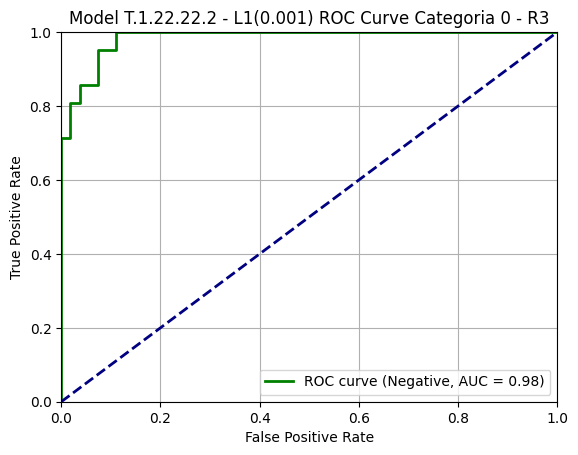

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

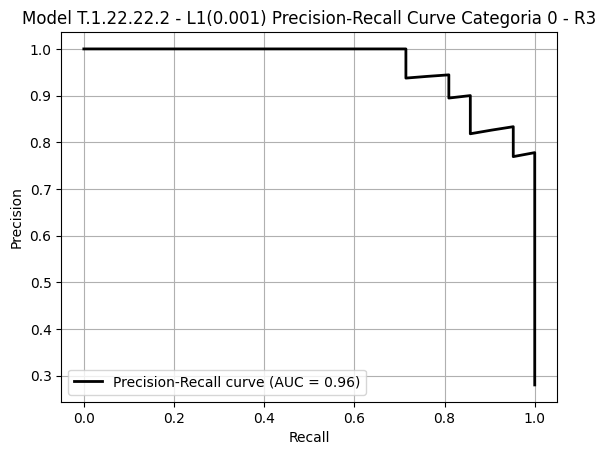

In [134]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Obter probabilidades previstas para ambas as classes
y_probas_positive_3 = probabilidades_3[:, 1]  # Probabilidades para a classe positiva
y_probas_negative_3 = probabilidades_3[:, 0]  # Probabilidades para a classe negativa

# Gerar e plotar a curva ROC para a classe positiva - 1
fpr_pos_3, tpr_pos_3, _ = roc_curve(dataset_teste.classes, y_probas_positive_3)
roc_auc_pos_3 = auc(fpr_pos_3, tpr_pos_3)
plt.figure()
plt.plot(fpr_pos_3, tpr_pos_3, color='green', lw=2, label=f'ROC curve (Positive, AUC = {roc_auc_pos_3:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # plotar a linha pontilhada de 50%
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 1 - R3')
plt.legend(loc="lower right")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 1 - R3.pdf"); # salvar a figura em png
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 1 - R3.pdf")

# Gerar e plotar a curva Precision-Recall para a classe positiva - 1
precision_pos_3, recall_pos_3, _ = precision_recall_curve(dataset_teste.classes, y_probas_positive_3)
pr_auc_pos_3 = auc(recall_pos_3, precision_pos_3)
plt.figure()
plt.plot(recall_pos_3, precision_pos_3, color='black', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc_pos_3:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title('Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 1 - R3')
plt.legend(loc="lower left")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 1- R3.pdf"); # salvar a figura em png
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 1- R3.pdf") # Baixar o arquivo
plt.show()

# Gerar e plotar a curva ROC para a classe negativa - 0
fpr_neg_3, tpr_neg_3, _ = roc_curve(1 - dataset_teste.classes, y_probas_negative_3)
roc_auc_neg_3 = auc(fpr_neg_3, tpr_neg_3)
plt.figure()
plt.plot(fpr_neg_3, tpr_neg_3, color='green', lw=2, label=f'ROC curve (Negative, AUC = {roc_auc_neg_3:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 0 - R3')
plt.legend(loc="lower right")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 0 - R3.pdf"); # salvar a figura em pdf
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 0 - R3.pdf") # Baixar o arquivo
plt.show()

# Gerar e plotar a curva Precision-Recall para a classe negativa - 0
precision_neg_3, recall_neg_3, _ = precision_recall_curve(1 - dataset_teste.classes, y_probas_negative_3)
pr_auc_neg_3 = auc(recall_neg_3, precision_neg_3)
plt.figure()
plt.plot(recall_neg_3, precision_neg_3, color='black', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc_neg_3:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title('Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 0 - R3')
plt.legend(loc="lower left")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 0 - R3.pdf"); # salvar a figura em pdf
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 0 - R3.pdf") # Baixar o arquivo
plt.show()

# Salvar a rede neural

In [135]:
model_json = network3.to_json()
with open('/content/Downloads/T.1.22.22.2_3.json','w') as json_file:
  json_file.write(model_json)


In [136]:
from keras.models import save_model

network_saved = save_model(network3, '/content/Downloads/weights_T.1.22.22.2_3.hdf5')

# Carregar a rede neural

In [137]:
# with open('T.1.22.22.2_3.json', 'r') as json_file:
#   json_saved_model = json_file.read()
# json_saved_model

In [138]:
# network_loaded = tf.keras.models.model_from_json(json_saved_model)
# network_loaded.load_weights('weights_T.1.22.22.2_3.hdf5')
# network_loaded.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4) , metrics=[tf.keras.metrics.AUC(curve='PR'), 'accuracy'])

##############################################################################
##############################################################################

## **Rodada 4**

## **Resetando a base de imagens**

In [139]:
# deletando os diretorios

import shutil

def delete_directory(directory_path):
  """Deletes a directory and its contents.

  Args:
    directory_path: The path to the directory to delete.
  """
  try:
    shutil.rmtree(directory_path)
    print(f"Directory '{directory_path}' deleted successfully.")
  except FileNotFoundError:
    print(f"Directory '{directory_path}' not found.")
  except OSError as e:
    print(f"Error deleting directory '{directory_path}': {e}")

# Example usage:
delete_directory("/content/test")
delete_directory("/content/train")
delete_directory("/content/validation")
delete_directory("/content/Base_2_Classes_B_R")

Directory '/content/test' deleted successfully.
Directory '/content/train' deleted successfully.
Directory '/content/validation' deleted successfully.
Directory '/content/Base_2_Classes_B_R' deleted successfully.


## Subindo o arquivo zipado com as imagens

In [140]:
!unzip -q Base_2_Classes_B_R.zip
!ls

Base_2_Classes_B_R		    classification_report_rodada_3.txt
Base_2_Classes_B_R.zip		    Downloads
classification_report_rodada_1.txt  sample_data
classification_report_rodada_2.txt


In [141]:
!ls Base_2_Classes_B_R

00R  01B


In [142]:
import os

# Todas as categorias
num_skipped = 0
for folder_name in ("00R", "01B"): # descrevendo as pastas presentes dentro do arquivo main "Base"
    folder_path = os.path.join("Base_2_Classes_B_R", folder_name) # juntando o caminho de cada uma das pastas com o caminho da main pasta
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) # estabelecendo o caminho completo de cada imagem dentro da pasta main e subpastas
        try:
            fobj = open(fpath, "rb") # lendo e abrindo cada uma das imagens
            is_pfif = tf.compat.as_bytes("PFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.png'
            # (T.1.0.3.1)
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.jpg'
            #
        finally:
            fobj.close()

print("Deletadas %d imagens" % num_skipped)

Deletadas 0 imagens


# Gerando os Datasets de treino, teste e validação randomicamente

In [143]:
import os
import random
from shutil import copyfile

# Diretório original das imagens
original_dataset_dir = '/content/Base_2_Classes_B_R'

# Diretório de destino para os conjuntos de treinamento, teste e validação
base_dir = '/content'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

val_dir = os.path.join(base_dir, 'validation')
os.makedirs(val_dir, exist_ok=True)

# Lista de classes (subdiretórios) no diretório original
classes = os.listdir(original_dataset_dir)

# Defina as proporções de imagens para treinamento (80%), teste (10%) e validação (10%)
train_split = 0.8
test_split = 0.1

# Itera sobre cada classe para criar os conjuntos de treinamento, teste e validação
for class_name in classes:
    class_dir = os.path.join(original_dataset_dir, class_name)

    # Lista de todas as imagens na classe
    images = os.listdir(class_dir)

    # Embaralha a lista de imagens para dividir aleatoriamente
    random.shuffle(images)

    # Calcula os índices para dividir entre treinamento, teste e validação
    train_index = int(len(images) * train_split)
    test_index = train_index + int(len(images) * test_split)

    # Lista de imagens para treinamento, teste e validação
    train_images = images[:train_index]
    test_images = images[train_index:test_index]
    val_images = images[test_index:]

    # Cria os subdiretórios de treinamento, teste e validação para a classe
    train_class_dir = os.path.join(train_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)

    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(test_class_dir, exist_ok=True)

    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(val_class_dir, exist_ok=True)

    # Copia as imagens para os diretórios de treinamento, teste e validação
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_class_dir, img)
        copyfile(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_class_dir, img)
        copyfile(src, dst)

    for img in val_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(val_class_dir, img)
        copyfile(src, dst)

print('Feito!')


Feito!


# Dataset Treino + Data Augmentation

In [144]:
gerador_treinamento = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input,
                                        #Data Augmentation
                                        zoom_range=0.2,
                                        rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

dataset_treinamento = gerador_treinamento.flow_from_directory('/content/train',
                                                              target_size=(224,224),
                                                              color_mode = 'rgb',
                                                              batch_size=16,
                                                              class_mode='categorical',
                                                              shuffle = True) # as imagens do dataset serão embaralhadas antes de cada época

Found 604 images belonging to 2 classes.


In [145]:
dataset_treinamento.class_indices

{'00R': 0, '01B': 1}

In [146]:
dataset_treinamento.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Dataset Validação

In [147]:
gerador_validacao = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

dataset_validacao = gerador_validacao.flow_from_directory('/content/validation',
                                                              target_size=(224,224),
                                                              color_mode = 'rgb',
                                                              batch_size=16,
                                                              class_mode='categorical',
                                                              shuffle = False) # as imagens do dataset NÃO serão embaralhadas antes de cada época na validação. É um teste do modelo depois de cada época

Found 76 images belonging to 2 classes.


# Dataset Teste

In [148]:
gerador_teste = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

dataset_teste = gerador_teste.flow_from_directory('/content/test',
                                                  target_size=(224,224),
                                                  color_mode = 'rgb',
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 75 images belonging to 2 classes.


# Rede neural pré-treinada
- Documentação: https://keras.io/api/applications/


## VGG-19

In [149]:
# modelo_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

## ResNet50

In [150]:
modelo_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

## ResNet101

In [151]:
# modelo_base = tf.keras.applications.ResNet101(weights='imagenet', include_top=False)

## ResNet152V2

In [152]:
# modelo_base = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False)

In [153]:
modelo_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [154]:
len(modelo_base.layers)

175

In [155]:
for layer in modelo_base.layers:
  #print(layer)
  layer.trainable = False

In [156]:
for layer in modelo_base.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer_3, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True>

# Camada densa personalizada

In [157]:
modelo_base.output

<KerasTensor shape=(None, None, None, 2048), dtype=float32, sparse=False, ragged=False, name=keras_tensor_714>

In [158]:
from functools import partial

RegularizadedDense = partial(keras.layers.Dense,
                             activation = "elu",
                             kernel_initializer = "he_normal",
                             kernel_regularizer = keras.regularizers.L1(0.001))

head_model = modelo_base.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = RegularizadedDense(1029)(head_model)
head_model = RegularizadedDense(514)(head_model)
head_model = RegularizadedDense(257)(head_model)
head_model = RegularizadedDense(units=2, activation='softmax')(head_model) # Função de ativação = "softmax" para ver a probabilidade entre as duas classes

print('Feito!')

Feito!


# Construção e treinamento da rede neural

In [159]:
modelo_base.input

<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_540>

In [160]:
network4 = Model(inputs = modelo_base.input, outputs = head_model)

In [161]:
for layer in network4.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer_3, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True>

In [162]:
network4.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 26,358,424 (100.55 MB)

 Trainable params: 2,770,712 (10.57 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Compilando o Modelo

In [163]:
# Compilar o modelo
network4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4), loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(curve='PR'), 'accuracy'])  # AUC da curva Precision-Recall

# Definir o callback de Early Stopping para inicio apos 50 epocas
early_stopping_4 = EarlyStopping(monitor='val_auc_3', patience=5, mode='max', min_delta=0.001, verbose=1, baseline=None, restore_best_weights=True, start_from_epoch=50)

print("Feito")

Feito


In [164]:
# Treinamento
history_4 = network4.fit(dataset_treinamento, epochs=100, validation_data=dataset_validacao, callbacks=[early_stopping_4])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 529ms/step - accuracy: 0.7371 - auc_3: 0.7857 - loss: 79.2878 - val_accuracy: 0.8816 - val_auc_3: 0.9292 - val_loss: 74.0258
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.8772 - auc_3: 0.9443 - loss: 72.1486 - val_accuracy: 0.8553 - val_auc_3: 0.9521 - val_loss: 66.9382
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.8996 - auc_3: 0.9628 - loss: 65.1944 - val_accuracy: 0.9079 - val_auc_3: 0.9466 - val_loss: 60.2874
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.8722 - auc_3: 0.9466 - loss: 58.7212 - val_accuracy: 0.8553 - val_auc_3: 0.9547 - val_loss: 54.1205
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.8951 - auc_3: 0.9607 - loss: 52.6533 - val_accuracy: 0.8816 - val_auc_3: 0.9679 - val_loss: 48.4590
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.9026 - auc_3: 0.9707 - loss: 47.1259 - val_accuracy: 0.8684 - val_auc_3: 0.9644 - val_loss: 4

# Avaliação da rede neural

In [165]:
history_4.history.keys()

dict_keys(['accuracy', 'auc_3', 'loss', 'val_accuracy', 'val_auc_3', 'val_loss'])

In [166]:
# Estabelecendo os parâmetros para plotagem
loss_4 = np.array(history_4.history['loss'])
loss_val_4 = np.array(history_4.history['val_loss'])

acc_4 = np.array(history_4.history['accuracy'])
acc_val_4 = np.array(history_4.history['val_accuracy'])

epochs_4 = range(len(history_4.history['loss']))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

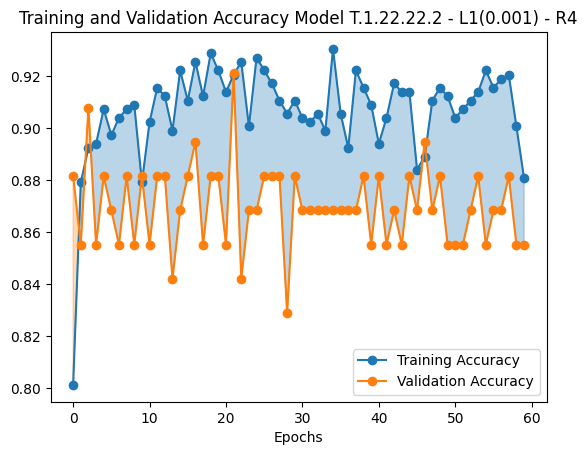

In [167]:
# Acurácia do Modelo

plt.figure()
plt.plot(acc_4, label='Training Accuracy', marker='o')
plt.plot(acc_val_4, label='Validation Accuracy', marker='o')
plt.fill_between(epochs_4, acc_4, acc_val_4, where=(acc_4 > acc_val_4), color='C0', alpha=0.3, interpolate=True)
plt.fill_between(epochs_4, acc_4, acc_val_4, where=(acc_4 < acc_val_4), color='C1', alpha=0.3, interpolate=True)
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy Model T.1.22.22.2 - L1(0.001) - R4')
plt.legend()
plt.savefig("/content/Downloads/Training and Validation Accuracy Model T.1.22.22.2 - L1(0.001) - R4.png"); # salvar a figura em pdf
files.download("/content/Downloads/Training and Validation Accuracy Model T.1.22.22.2 - L1(0.001) - R4.png") # Baixar o arquivo


plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

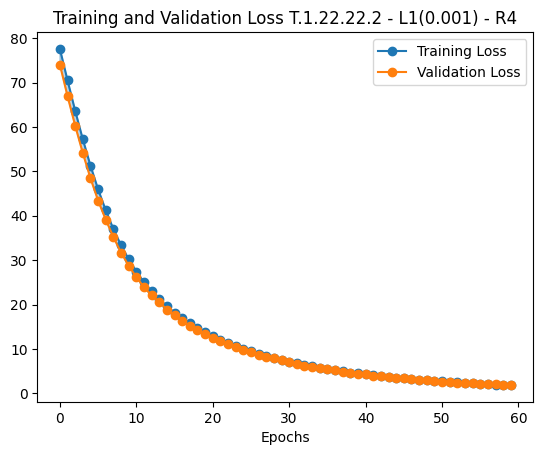

In [168]:
# Erro do Modelo

plt.figure()
plt.plot(loss_4, label='Training Loss', marker='o')
plt.plot(loss_val_4, label='Validation Loss', marker='o')
plt.fill_between(epochs_4, loss_4, loss_val_4, where=(loss_4 > loss_val_4), color='C0', alpha=0.3, interpolate=True)
plt.fill_between(epochs_4, loss_4, loss_val_4, where=(loss_4 < loss_val_4), color='C1', alpha=0.3, interpolate=True)
plt.xlabel('Epochs')
plt.title('Training and Validation Loss T.1.22.22.2 - L1(0.001) - R4')
plt.legend()
plt.savefig("/content/Downloads/Training and Validation Loss T.1.22.22.2 - L1(0.001) - R4.png"); # salvar a figura em pdf
files.download("/content/Downloads/Training and Validation Loss T.1.22.22.2 - L1(0.001) - R4.png") # Baixar o arquivo

plt.show()

In [169]:
dataset_teste.class_indices

{'00R': 0, '01B': 1}

In [170]:
probabilidades_4 = network4.predict(dataset_teste)
probabilidades_4

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


array([[0.96257985, 0.03742014],
       [0.77206206, 0.2279379 ],
       [0.35744762, 0.6425523 ],
       [0.22075053, 0.7792495 ],
       [0.9904736 , 0.00952639],
       [0.5462552 , 0.4537448 ],
       [0.98914486, 0.01085513],
       [0.9952697 , 0.00473026],
       [0.9963305 , 0.00366943],
       [0.42405194, 0.57594806],
       [0.19938119, 0.8006189 ],
       [0.29300952, 0.70699054],
       [0.27819335, 0.72180665],
       [0.42599773, 0.57400227],
       [0.9978642 , 0.00213586],
       [0.9955622 , 0.00443778],
       [0.9915081 , 0.00849186],
       [0.99703515, 0.00296486],
       [0.99731773, 0.00268221],
       [0.99661404, 0.00338596],
       [0.9817748 , 0.01822519],
       [0.02815704, 0.9718429 ],
       [0.01372439, 0.98627555],
       [0.28909612, 0.7109039 ],
       [0.04449342, 0.95550656],
       [0.01954936, 0.98045063],
       [0.00683263, 0.99316734],
       [0.01866915, 0.9813308 ],
       [0.0065257 , 0.9934743 ],
       [0.01951758, 0.98048246],
       [0.

In [171]:
# índice da coluna com maior probabilidade
previsoes_4 = np.argmax(probabilidades_4, axis = 1) # - vetor com 0 ou 1 - escolhe a coluna do maior item no vetor

# vetor com as maiores probabilidades
prob_previsoes_4 = np.amax(probabilidades_4, axis=1) # - vetor com as maiores probabilidades

print("Previsões 4")
print(" ")
print(previsoes_4)

Previsões 4
 
[0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1]


In [172]:
dataset_teste.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

# Avaliação do Modelo

In [173]:
# Evaluate the model
model_evaluation = network4.evaluate(dataset_teste)

75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7688 - auc_3: 0.9155 - loss: 2.3377


# Matriz de Confusão

In [174]:
# Acurácia do Modelo

from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes_4)

0.8533333333333334

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

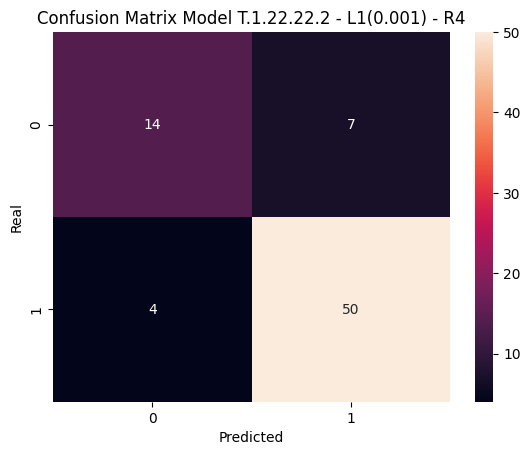

In [175]:
from sklearn.metrics import confusion_matrix
cm_4 = confusion_matrix(dataset_teste.classes, previsoes_4)

plt.figure()
plt.title('Confusion Matrix Model T.1.22.22.2 - L1(0.001) - R4')

sns.heatmap(cm_4, annot=True)

plt.xlabel('Predicted')
plt.ylabel('Real')

plt.savefig("/content/Downloads/Confusion Matrix Model T.1.22.22.2 - L1(0.001) - R4.png"); # salvar a figura em pdf
files.download("/content/Downloads/Confusion Matrix Model T.1.22.22.2 - L1(0.001) - R4.png") # Baixar o arquivo

plt.show()

In [176]:
from sklearn.metrics import classification_report
print("RODADA 4")
print("")
print(classification_report(dataset_teste.classes, previsoes_4))
classification_report_rodada_4 = classification_report(dataset_teste.classes, previsoes_4)

# Salvar em .txt
file_name = "classification_report_rodada_4.txt"
with open(file_name, 'w') as file:
    file.write(classification_report_rodada_4)

# Baixar o arquivo
files.download(file_name)

RODADA 4

              precision    recall  f1-score   support

           0       0.78      0.67      0.72        21
           1       0.88      0.93      0.90        54

    accuracy                           0.85        75
   macro avg       0.83      0.80      0.81        75
weighted avg       0.85      0.85      0.85        75



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [177]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Estabelecendo os parametros para formar o AUC
fpr_4, tpr_4, thresholds_4 = roc_curve(dataset_teste.classes, previsoes_4)
roc_auc_4 = roc_auc_score(dataset_teste.classes, previsoes_4)

print(f'AUC: {roc_auc_4:.2f}')

AUC: 0.80


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

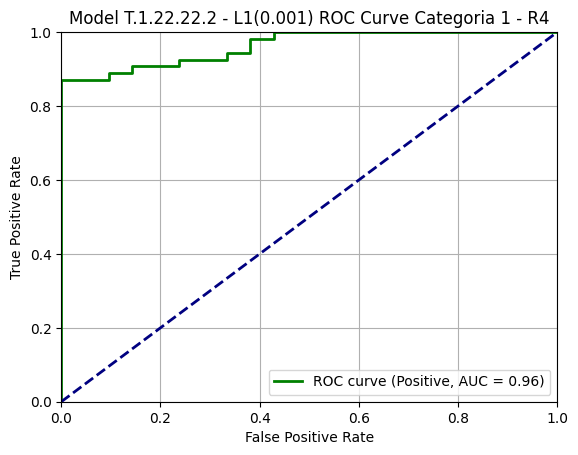

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

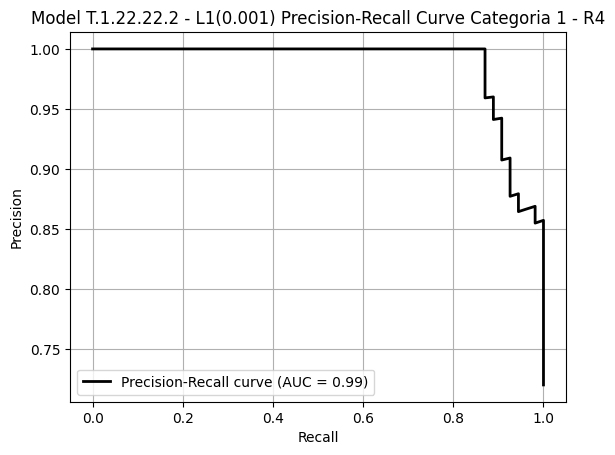

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

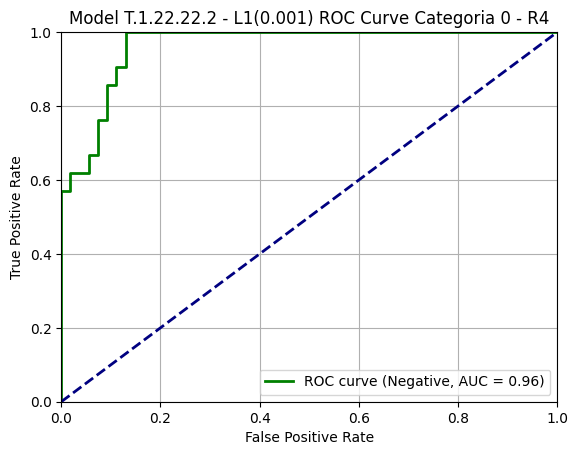

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

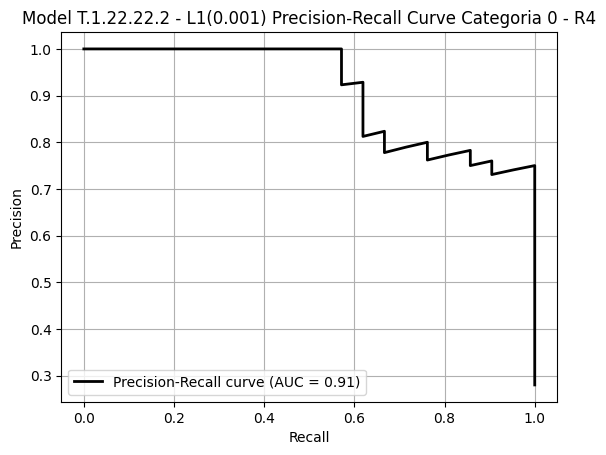

In [178]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Obter probabilidades previstas para ambas as classes
y_probas_positive_4 = probabilidades_4[:, 1]  # Probabilidades para a classe positiva
y_probas_negative_4 = probabilidades_4[:, 0]  # Probabilidades para a classe negativa

# Gerar e plotar a curva ROC para a classe positiva - 1
fpr_pos_4, tpr_pos_4, _ = roc_curve(dataset_teste.classes, y_probas_positive_4)
roc_auc_pos_4 = auc(fpr_pos_4, tpr_pos_4)
plt.figure()
plt.plot(fpr_pos_4, tpr_pos_4, color='green', lw=2, label=f'ROC curve (Positive, AUC = {roc_auc_pos_4:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # plotar a linha pontilhada de 50%
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 1 - R4')
plt.legend(loc="lower right")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 1 - R4.pdf"); # salvar a figura em png
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 1 - R4.pdf") # Baixar o arquivo
plt.show()

# Gerar e plotar a curva Precision-Recall para a classe positiva - 1
precision_pos_4, recall_pos_4, _ = precision_recall_curve(dataset_teste.classes, y_probas_positive_4)
pr_auc_pos_4 = auc(recall_pos_4, precision_pos_4)
plt.figure()
plt.plot(recall_pos_4, precision_pos_4, color='black', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc_pos_4:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title('Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 1 - R4')
plt.legend(loc="lower left")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 1 - R4.pdf"); # salvar a figura em png
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 1 - R4.pdf") # Baixar o arquivo
plt.show()

# Gerar e plotar a curva ROC para a classe negativa - 0
fpr_neg_4, tpr_neg_4, _ = roc_curve(1 - dataset_teste.classes, y_probas_negative_4)
roc_auc_neg_4 = auc(fpr_neg_4, tpr_neg_4)
plt.figure()
plt.plot(fpr_neg_4, tpr_neg_4, color='green', lw=2, label=f'ROC curve (Negative, AUC = {roc_auc_neg_4:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 0 - R4')
plt.legend(loc="lower right")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 0 - R4.pdf"); # salvar a figura em pdf
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 0 - R4.pdf") # Baixar o arquivo
plt.show()

# Gerar e plotar a curva Precision-Recall para a classe negativa - 0
precision_neg_4, recall_neg_4, _ = precision_recall_curve(1 - dataset_teste.classes, y_probas_negative_4)
pr_auc_neg_4 = auc(recall_neg_4, precision_neg_4)
plt.figure()
plt.plot(recall_neg_4, precision_neg_4, color='black', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc_neg_4:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title('Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 0 - R4')
plt.legend(loc="lower left")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 0 - R4.pdf"); # salvar a figura em pdf
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 0 - R4.pdf") # Baixar o arquivo
plt.show()

# Salvar a rede neural

In [179]:
model_json = network4.to_json()
with open('/content/Downloads/T.1.22.22.2_4.json','w') as json_file:
  json_file.write(model_json)


In [180]:
from keras.models import save_model

# Salvando a rede neural
network_saved = save_model(network4, '/content/Downloads/weights_T.1.22.22.2_4.hdf5')

# Carregar a rede neural

In [181]:
# with open('T.1.22.22.2_4.json', 'r') as json_file:
#   json_saved_model = json_file.read()
# json_saved_model

In [182]:
# network_loaded = tf.keras.models.model_from_json(json_saved_model)
# network_loaded.load_weights('weights_T.1.22.22.2_4.hdf5')
# network_loaded.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4) , metrics=[tf.keras.metrics.AUC(curve='PR'), 'accuracy'])

##############################################################################
##############################################################################

## **Rodada 5**

## **Resetando a base de imagens**

In [183]:
# deletando os diretorios

import shutil

def delete_directory(directory_path):
  """Deletes a directory and its contents.

  Args:
    directory_path: The path to the directory to delete.
  """
  try:
    shutil.rmtree(directory_path)
    print(f"Directory '{directory_path}' deleted successfully.")
  except FileNotFoundError:
    print(f"Directory '{directory_path}' not found.")
  except OSError as e:
    print(f"Error deleting directory '{directory_path}': {e}")

# Example usage:
delete_directory("/content/test")
delete_directory("/content/train")
delete_directory("/content/validation")
delete_directory("/content/Base_2_Classes_B_R")

Directory '/content/test' deleted successfully.
Directory '/content/train' deleted successfully.
Directory '/content/validation' deleted successfully.
Directory '/content/Base_2_Classes_B_R' deleted successfully.


## Subindo o arquivo zipado com as imagens

In [184]:
!unzip -q Base_2_Classes_B_R.zip
!ls

Base_2_Classes_B_R		    classification_report_rodada_3.txt
Base_2_Classes_B_R.zip		    classification_report_rodada_4.txt
classification_report_rodada_1.txt  Downloads
classification_report_rodada_2.txt  sample_data


In [185]:
!ls Base_2_Classes_B_R

00R  01B


In [186]:
import os

# Todas as categorias
num_skipped = 0
for folder_name in ("00R", "01B"): # descrevendo as pastas presentes dentro do arquivo main "Base"
    folder_path = os.path.join("Base_2_Classes_B_R", folder_name) # juntando o caminho de cada uma das pastas com o caminho da main pasta
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) # estabelecendo o caminho completo de cada imagem dentro da pasta main e subpastas
        try:
            fobj = open(fpath, "rb") # lendo e abrindo cada uma das imagens
            is_pfif = tf.compat.as_bytes("PFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.png'
            # (T.1.0.3.1)
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.jpg'
            #
        finally:
            fobj.close()

print("Deletadas %d imagens" % num_skipped)

Deletadas 0 imagens


# Gerando os Datasets de treino, teste e validação randomicamente

In [187]:
import os
import random
from shutil import copyfile

# Diretório original das imagens
original_dataset_dir = '/content/Base_2_Classes_B_R'

# Diretório de destino para os conjuntos de treinamento, teste e validação
base_dir = '/content'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

val_dir = os.path.join(base_dir, 'validation')
os.makedirs(val_dir, exist_ok=True)

# Lista de classes (subdiretórios) no diretório original
classes = os.listdir(original_dataset_dir)

# Defina as proporções de imagens para treinamento (80%), teste (10%) e validação (10%)
train_split = 0.8
test_split = 0.1

# Itera sobre cada classe para criar os conjuntos de treinamento, teste e validação
for class_name in classes:
    class_dir = os.path.join(original_dataset_dir, class_name)

    # Lista de todas as imagens na classe
    images = os.listdir(class_dir)

    # Embaralha a lista de imagens para dividir aleatoriamente
    random.shuffle(images)

    # Calcula os índices para dividir entre treinamento, teste e validação
    train_index = int(len(images) * train_split)
    test_index = train_index + int(len(images) * test_split)

    # Lista de imagens para treinamento, teste e validação
    train_images = images[:train_index]
    test_images = images[train_index:test_index]
    val_images = images[test_index:]

    # Cria os subdiretórios de treinamento, teste e validação para a classe
    train_class_dir = os.path.join(train_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)

    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(test_class_dir, exist_ok=True)

    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(val_class_dir, exist_ok=True)

    # Copia as imagens para os diretórios de treinamento, teste e validação
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_class_dir, img)
        copyfile(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_class_dir, img)
        copyfile(src, dst)

    for img in val_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(val_class_dir, img)
        copyfile(src, dst)

print('Feito!')


Feito!


# Dataset Treino + Data Augmentation

In [188]:
gerador_treinamento = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input,
                                        #Data Augmentation
                                        zoom_range=0.2,
                                        rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

dataset_treinamento = gerador_treinamento.flow_from_directory('/content/train',
                                                              target_size=(224,224),
                                                              color_mode = 'rgb',
                                                              batch_size=16,
                                                              class_mode='categorical',
                                                              shuffle = True) # as imagens do dataset serão embaralhadas antes de cada época

Found 604 images belonging to 2 classes.


In [189]:
dataset_treinamento.class_indices

{'00R': 0, '01B': 1}

In [190]:
dataset_treinamento.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Dataset Validação

In [191]:
gerador_validacao = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

dataset_validacao = gerador_validacao.flow_from_directory('/content/validation',
                                                              target_size=(224,224),
                                                              color_mode = 'rgb',
                                                              batch_size=16,
                                                              class_mode='categorical',
                                                              shuffle = False) # as imagens do dataset NÃO serão embaralhadas antes de cada época na validação. É um teste do modelo depois de cada época

Found 76 images belonging to 2 classes.


# Dataset Teste

In [192]:
gerador_teste = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

dataset_teste = gerador_teste.flow_from_directory('/content/test',
                                                  target_size=(224,224),
                                                  color_mode = 'rgb',
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 75 images belonging to 2 classes.


# Rede neural pré-treinada
- Documentação: https://keras.io/api/applications/


## VGG-19

In [193]:
# modelo_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

## ResNet50

In [194]:
modelo_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

## ResNet101

In [195]:
# modelo_base = tf.keras.applications.ResNet101(weights='imagenet', include_top=False)

## ResNet152V2

In [196]:
# modelo_base = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False)

In [197]:
modelo_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [198]:
len(modelo_base.layers)

175

In [199]:
for layer in modelo_base.layers:
  #print(layer)
  layer.trainable = False

In [200]:
for layer in modelo_base.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer_4, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True>

# Camada densa personalizada

In [201]:
modelo_base.output

<KerasTensor shape=(None, None, None, 2048), dtype=float32, sparse=False, ragged=False, name=keras_tensor_894>

In [202]:
from functools import partial

RegularizadedDense = partial(keras.layers.Dense,
                             activation = "elu",
                             kernel_initializer = "he_normal",
                             kernel_regularizer = keras.regularizers.L1(0.001))

head_model = modelo_base.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = RegularizadedDense(1029)(head_model)
head_model = RegularizadedDense(514)(head_model)
head_model = RegularizadedDense(257)(head_model)
head_model = RegularizadedDense(units=2, activation='softmax')(head_model) # Função de ativação = "softmax" para ver a probabilidade entre as duas classes

print('Feito!')

Feito!


# Construção e treinamento da rede neural

In [203]:
modelo_base.input

<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_720>

In [204]:
network5 = Model(inputs = modelo_base.input, outputs = head_model)

In [205]:
for layer in network5.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer_4, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True>

In [206]:
network5.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 26,358,424 (100.55 MB)

 Trainable params: 2,770,712 (10.57 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Compilando o Modelo

In [207]:
# Compilar o modelo
network5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4), loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(curve='PR'), 'accuracy'])  # AUC da curva Precision-Recall

# Definir o callback de Early Stopping para inicio apos 50 epocas
early_stopping_5 = EarlyStopping(monitor='val_auc_4', patience=5, mode='max', min_delta=0.001, verbose=1, baseline=None, restore_best_weights=True, start_from_epoch=50)

print("Feito")

Feito


In [208]:
# Treinamento
history_5 = network5.fit(dataset_treinamento, epochs=100, validation_data=dataset_validacao, callbacks=[early_stopping_5])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 529ms/step - accuracy: 0.7509 - auc_4: 0.7847 - loss: 79.4305 - val_accuracy: 0.8158 - val_auc_4: 0.8873 - val_loss: 74.2403
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.8850 - auc_4: 0.9419 - loss: 72.1596 - val_accuracy: 0.8026 - val_auc_4: 0.9137 - val_loss: 67.2315
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.9092 - auc_4: 0.9617 - loss: 65.1620 - val_accuracy: 0.8553 - val_auc_4: 0.9258 - val_loss: 60.2427
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.8582 - auc_4: 0.9199 - loss: 58.6970 - val_accuracy: 0.8684 - val_auc_4: 0.9448 - val_loss: 54.0450
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.8753 - auc_4: 0.9554 - loss: 52.5679 - val_accuracy: 0.8947 - val_auc_4: 0.9396 - val_loss: 48.4256
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.9105 - auc_4: 0.9706 - loss: 47.0398 - val_accuracy: 0.8421 - val_auc_4: 0.9452 - val_loss: 4

# Avaliação da rede neural

In [209]:
history_5.history.keys()

dict_keys(['accuracy', 'auc_4', 'loss', 'val_accuracy', 'val_auc_4', 'val_loss'])

In [210]:
# Estabelecendo os parâmetros para plotagem
loss_5 = np.array(history_5.history['loss'])
loss_val_5 = np.array(history_5.history['val_loss'])

acc_5 = np.array(history_5.history['accuracy'])
acc_val_5 = np.array(history_5.history['val_accuracy'])

epochs_5 = range(len(history_5.history['loss']))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

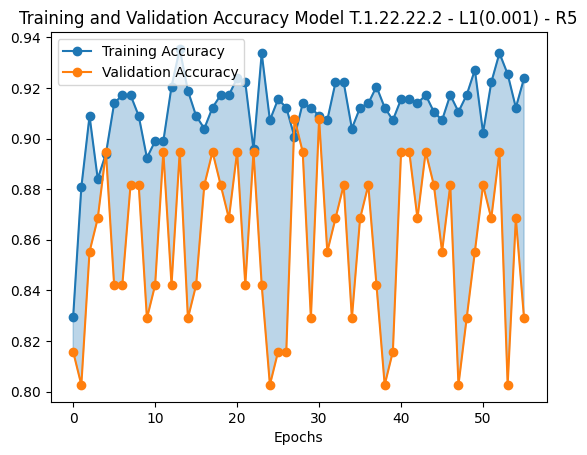

In [211]:
# Acurácia do Modelo

plt.figure()
plt.plot(acc_5, label='Training Accuracy', marker='o')
plt.plot(acc_val_5, label='Validation Accuracy', marker='o')
plt.fill_between(epochs_5, acc_5, acc_val_5, where=(acc_5 > acc_val_5), color='C0', alpha=0.3, interpolate=True)
plt.fill_between(epochs_5, acc_5, acc_val_5, where=(acc_5 < acc_val_5), color='C1', alpha=0.3, interpolate=True)
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy Model T.1.22.22.2 - L1(0.001) - R5')
plt.legend()
plt.savefig("/content/Downloads/Training and Validation Accuracy Model T.1.22.22.2 - L1(0.001) - R5.png"); # salvar a figura em pdf
files.download("/content/Downloads/Training and Validation Accuracy Model T.1.22.22.2 - L1(0.001) - R5.png") # Baixar o arquivo


plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

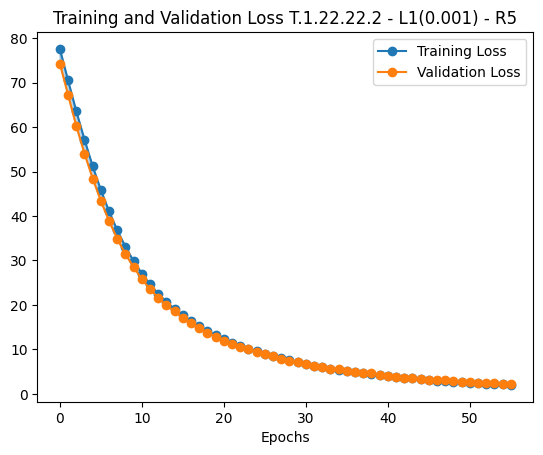

In [212]:
# Erro do Modelo

plt.figure()
plt.plot(loss_5, label='Training Loss', marker='o')
plt.plot(loss_val_5, label='Validation Loss', marker='o')
plt.fill_between(epochs_5, loss_5, loss_val_5, where=(loss_5 > loss_val_5), color='C0', alpha=0.3, interpolate=True)
plt.fill_between(epochs_5, loss_5, loss_val_5, where=(loss_5 < loss_val_5), color='C1', alpha=0.3, interpolate=True)
plt.xlabel('Epochs')
plt.title('Training and Validation Loss T.1.22.22.2 - L1(0.001) - R5')
plt.legend()
plt.savefig("/content/Downloads/Training and Validation Loss T.1.22.22.2 - L1(0.001) - R5.png"); # salvar a figura em pdf
files.download("/content/Downloads/Training and Validation Loss T.1.22.22.2 - L1(0.001) - R5.png") # Baixar o arquivo

plt.show()

In [213]:
dataset_teste.class_indices

{'00R': 0, '01B': 1}

In [214]:
probabilidades_5 = network5.predict(dataset_teste)
probabilidades_5

75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


array([[0.9907394 , 0.0092606 ],
       [0.4212939 , 0.578706  ],
       [0.59742063, 0.40257937],
       [0.9327397 , 0.06726035],
       [0.8119103 , 0.18808976],
       [0.81787896, 0.18212104],
       [0.68593895, 0.31406105],
       [0.9882378 , 0.01176219],
       [0.6160967 , 0.38390338],
       [0.5864996 , 0.41350052],
       [0.28642926, 0.7135708 ],
       [0.34459254, 0.6554075 ],
       [0.8848529 , 0.11514708],
       [0.98190755, 0.01809245],
       [0.99336874, 0.00663127],
       [0.9949349 , 0.00506501],
       [0.9966521 , 0.0033478 ],
       [0.9983077 , 0.00169223],
       [0.9989482 , 0.00105177],
       [0.9947584 , 0.00524151],
       [0.99335456, 0.00664544],
       [0.04404124, 0.9559588 ],
       [0.08500888, 0.9149912 ],
       [0.07283295, 0.92716706],
       [0.08131046, 0.9186895 ],
       [0.02712025, 0.97287977],
       [0.02639555, 0.97360444],
       [0.04809364, 0.9519063 ],
       [0.07717896, 0.9228211 ],
       [0.01732106, 0.98267895],
       [0.

In [215]:
# índice da coluna com maior probabilidade
previsoes_5 = np.argmax(probabilidades_5, axis = 1) # - vetor com 0 ou 1 - escolhe a coluna do maior item no vetor

# vetor com as maiores probabilidades
prob_previsoes_5 = np.amax(probabilidades_5, axis=1) # - vetor com as maiores probabilidades

print("Previsões 5")
print(" ")
print(previsoes_5)

Previsões 5
 
[0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
 1]


In [216]:
dataset_teste.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

# Avaliação do Modelo

In [217]:
# Evaluate the model
model_evaluation = network5.evaluate(dataset_teste)

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8886 - auc_4: 0.9629 - loss: 2.5124


# Matriz de Confusão

In [218]:
# Acurácia do Modelo

from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes_5)

0.92

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

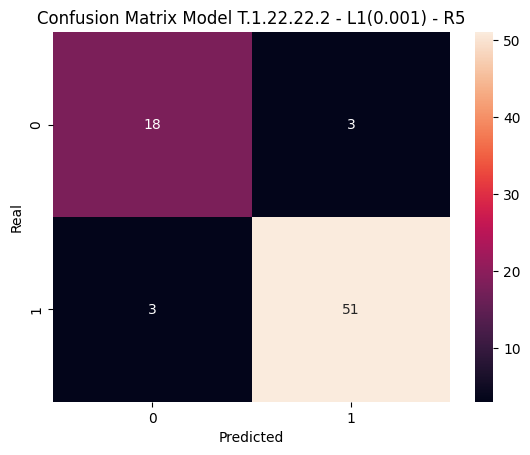

In [219]:
from sklearn.metrics import confusion_matrix
cm_5 = confusion_matrix(dataset_teste.classes, previsoes_5)

# # (T.4.16.18.1)
plt.figure()
plt.title('Confusion Matrix Model T.1.22.22.2 - L1(0.001) - R5')

sns.heatmap(cm_5, annot=True)

plt.xlabel('Predicted')
plt.ylabel('Real')

plt.savefig("/content/Downloads/Confusion Matrix Model T.1.22.22.2 - L1(0.001) - R5.png"); # salvar a figura em pdf
files.download("/content/Downloads/Confusion Matrix Model T.1.22.22.2 - L1(0.001) - R5.png") # Baixar o arquivo

plt.show()

In [220]:
from sklearn.metrics import classification_report
print("RODADA 5")
print("")
print(classification_report(dataset_teste.classes, previsoes_5))
classification_report_rodada_5 = classification_report(dataset_teste.classes, previsoes_5)

# Salvar em .txt
file_name = "classification_report_rodada_5.txt"
with open(file_name, 'w') as file:
    file.write(classification_report_rodada_5)

# Baixar o arquivo
files.download(file_name)

RODADA 5

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       0.94      0.94      0.94        54

    accuracy                           0.92        75
   macro avg       0.90      0.90      0.90        75
weighted avg       0.92      0.92      0.92        75



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [221]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Estabelecendo os parametros para formar o AUC
fpr_5, tpr_5, thresholds_5 = roc_curve(dataset_teste.classes, previsoes_5)
roc_auc_5 = roc_auc_score(dataset_teste.classes, previsoes_5)

print(f'AUC: {roc_auc_5:.2f}')

AUC: 0.90


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

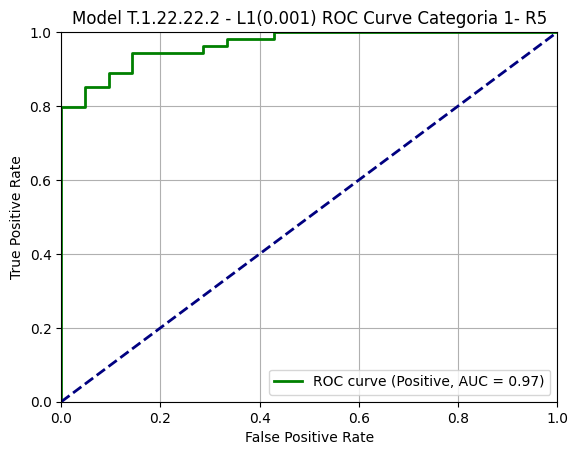

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

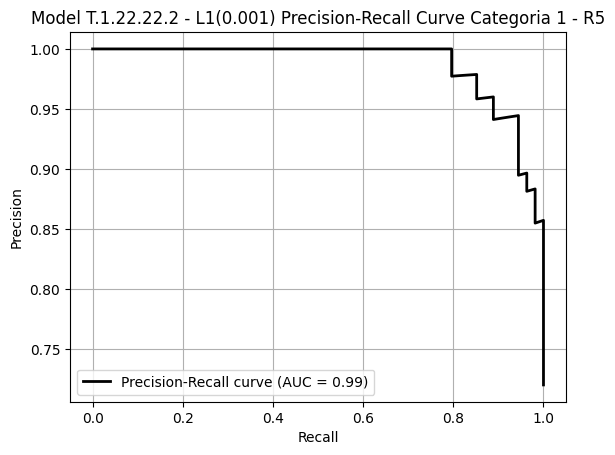

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

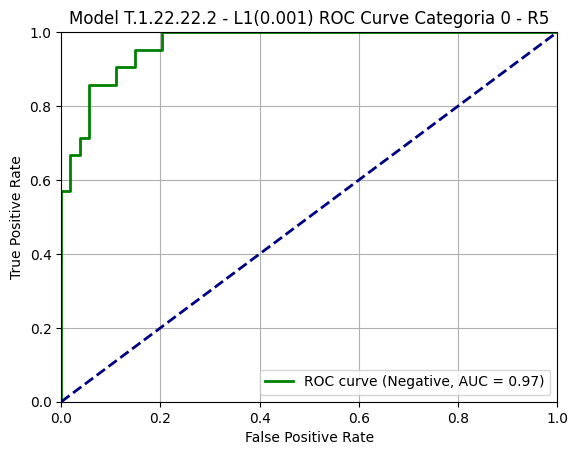

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

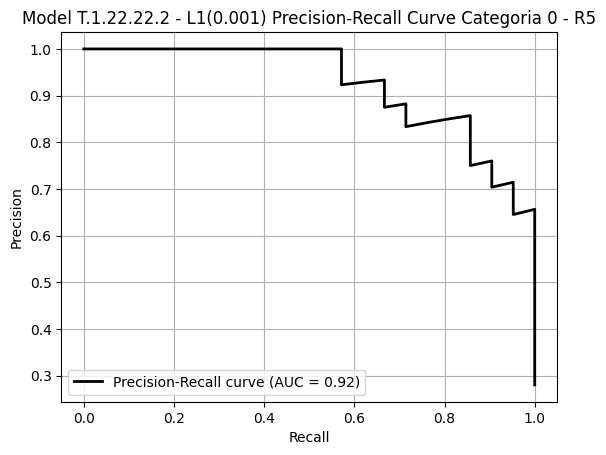

In [222]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Obter probabilidades previstas para ambas as classes
y_probas_positive_5 = probabilidades_5[:, 1]  # Probabilidades para a classe positiva
y_probas_negative_5 = probabilidades_5[:, 0]  # Probabilidades para a classe negativa

# Gerar e plotar a curva ROC para a classe positiva - 1
fpr_pos_5, tpr_pos_5, _ = roc_curve(dataset_teste.classes, y_probas_positive_5)
roc_auc_pos_5 = auc(fpr_pos_5, tpr_pos_5)
plt.figure()
plt.plot(fpr_pos_5, tpr_pos_5, color='green', lw=2, label=f'ROC curve (Positive, AUC = {roc_auc_pos_5:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # plotar a linha pontilhada de 50%
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 1- R5')
plt.legend(loc="lower right")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 1 - R5.pdf"); # salvar a figura em png
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 1 - R5.pdf") # Baixar o arquivo
plt.show()

# Gerar e plotar a curva Precision-Recall para a classe positiva - 1
precision_pos_5, recall_pos_5, _ = precision_recall_curve(dataset_teste.classes, y_probas_positive_5)
pr_auc_pos_5 = auc(recall_pos_5, precision_pos_5)
plt.figure()
plt.plot(recall_pos_5, precision_pos_5, color='black', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc_pos_5:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title('Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 1 - R5')
plt.legend(loc="lower left")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 1 - R5.pdf"); # salvar a figura em png
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 1 - R5.pdf") # Baixar o arquivo
plt.show()

# Gerar e plotar a curva ROC para a classe negativa - 0
fpr_neg_5, tpr_neg_5, _ = roc_curve(1 - dataset_teste.classes, y_probas_negative_5)
roc_auc_neg_5 = auc(fpr_neg_5, tpr_neg_5)
plt.figure()
plt.plot(fpr_neg_5, tpr_neg_5, color='green', lw=2, label=f'ROC curve (Negative, AUC = {roc_auc_neg_5:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 0 - R5')
plt.legend(loc="lower right")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 0 - R5.pdf"); # salvar a figura em pdf
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Categoria 0 - R5.pdf") # Baixar o arquivo
plt.show()

# Gerar e plotar a curva Precision-Recall para a classe negativa - 0
precision_neg_5, recall_neg_5, _ = precision_recall_curve(1 - dataset_teste.classes, y_probas_negative_5)
pr_auc_neg_5 = auc(recall_neg_5, precision_neg_5)
plt.figure()
plt.plot(recall_neg_5, precision_neg_5, color='black', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc_neg_5:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title('Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 0 - R5')
plt.legend(loc="lower left")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 0 - R5.pdf"); # salvar a figura em pdf
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria 0 - R5.pdf") # Baixar o arquivo
plt.show()

# Salvar a rede neural

In [223]:
model_json = network5.to_json()
with open('/content/Downloads/T.1.22.22.2_5.json','w') as json_file:
  json_file.write(model_json)


In [224]:
from keras.models import save_model

# Salvando a rede neural
network_saved = save_model(network5, '/content/Downloads/weights_T.1.22.22.2_5.hdf5')

# Carregar a rede neural

In [225]:
# with open('T.1.22.22.2_5.json', 'r') as json_file:
#   json_saved_model = json_file.read()
# json_saved_model

In [226]:
# network_loaded = tf.keras.models.model_from_json(json_saved_model)
# network_loaded.load_weights('weights_T.1.22.22.2_5.hdf5')
# network_loaded.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4) , metrics=[tf.keras.metrics.AUC(curve='PR')])

## **Análise das Curvas de PR e ROC para as 5 Rodadas**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

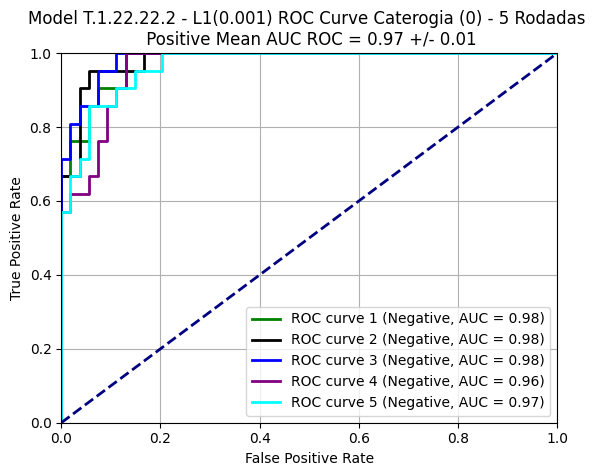

In [227]:
# Média AUC ROC
media_auc_roc = np.mean([roc_auc_neg_1, roc_auc_neg_2, roc_auc_neg_3, roc_auc_neg_4, roc_auc_neg_5])

# Desvio Padrão AUC ROC
dp_auc_roc = np.std([roc_auc_neg_1, roc_auc_neg_2, roc_auc_neg_3, roc_auc_neg_4, roc_auc_neg_5], ddof=1)

# Plotando figura
plt.figure()

plt.plot(fpr_neg_1, tpr_neg_1, color='green', lw=2, label=f'ROC curve 1 (Negative, AUC = {roc_auc_neg_1:.2f})')
plt.plot(fpr_neg_2, tpr_neg_2, color='black', lw=2, label=f'ROC curve 2 (Negative, AUC = {roc_auc_neg_2:.2f})')
plt.plot(fpr_neg_3, tpr_neg_3, color='blue', lw=2, label=f'ROC curve 3 (Negative, AUC = {roc_auc_neg_3:.2f})')
plt.plot(fpr_neg_4, tpr_neg_4, color='purple', lw=2, label=f'ROC curve 4 (Negative, AUC = {roc_auc_neg_4:.2f})')
plt.plot(fpr_neg_5, tpr_neg_5, color='cyan', lw=2, label=f'ROC curve 5 (Negative, AUC = {roc_auc_neg_5:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Model T.1.22.22.2 - L1(0.001) ROC Curve Caterogia (0) - 5 Rodadas \n Positive Mean AUC ROC = {media_auc_roc:.2f} +/- {dp_auc_roc:.2f}')
plt.legend(loc="lower right")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Caterogia (0) - 5 Rodadas.pdf"); # salvar a figura em pdf
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) ROC Curve Caterogia (0) - 5 Rodadas.pdf") # Baixar o arquivo

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

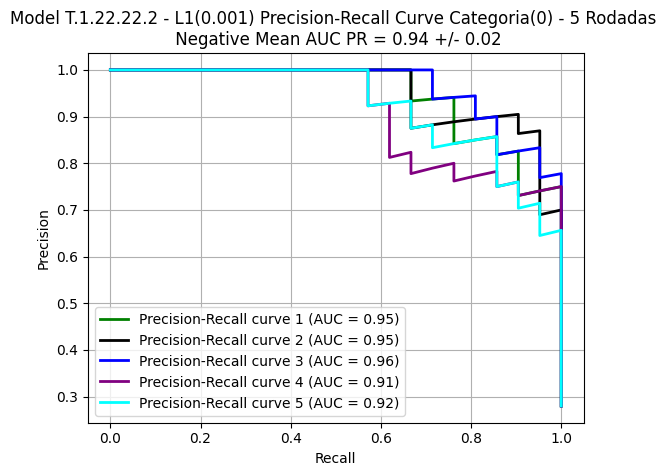

In [228]:
# Média AUC PR
media_auc_pr = np.mean([pr_auc_neg_1, pr_auc_neg_2, pr_auc_neg_3, pr_auc_neg_4, pr_auc_neg_5])

# Desvio Padrão AUC PR
dp_auc_pr = np.std([pr_auc_neg_1, pr_auc_neg_2, pr_auc_neg_3, pr_auc_neg_4, pr_auc_neg_5], ddof=1)

# Plotando figura
plt.figure()

plt.plot(recall_neg_1, precision_neg_1, color='green', lw=2, label=f'Precision-Recall curve 1 (AUC = {pr_auc_neg_1:.2f})')
plt.plot(recall_neg_2, precision_neg_2, color='black', lw=2, label=f'Precision-Recall curve 2 (AUC = {pr_auc_neg_2:.2f})')
plt.plot(recall_neg_3, precision_neg_3, color='blue', lw=2, label=f'Precision-Recall curve 3 (AUC = {pr_auc_neg_3:.2f})')
plt.plot(recall_neg_4, precision_neg_4, color='purple', lw=2, label=f'Precision-Recall curve 4 (AUC = {pr_auc_neg_4:.2f})')
plt.plot(recall_neg_5, precision_neg_5, color='cyan', lw=2, label=f'Precision-Recall curve 5 (AUC = {pr_auc_neg_5:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title(f'Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria(0) - 5 Rodadas \n Negative Mean AUC PR = {media_auc_pr:.2f} +/- {dp_auc_pr:.2f}')
plt.legend(loc="lower left")
plt.savefig("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria(0) - 5 Rodadas.pdf"); # salvar a figura em pdf
files.download("/content/Downloads/Model T.1.22.22.2 - L1(0.001) Precision-Recall Curve Categoria(0) - 5 Rodadas.pdf") # Baixar o arquivo

plt.show()

# Reset das variáveis

In [229]:
# %reset -f